<h1> CSCI 567 - Machine Learning - Spring 2021 </h1>
<h2> Project: Checkpoint 2 - Data Preprocessing (05/03/21) </h2>
<h3> Team <u>StochasticResults</u>: </h3>
 - Abel Salinas <br>
 - Angel Nieto  <br>
 - Misael Morales 

***

The "Housing Price" dataset consists of 79 predictors for the house prices in Ames, Iowa. The training and testing set are already pre-split for us from the Kaggle version (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), and we will focus on different regression techniques to predict the housing SalePrice based on the given features.

The first part of this notebook focuses on the data pre-processing, wrangling, visualization, and statistical analysis. It is a crucial step in any machine-learning/data-analytics application to ensure proper data formatting in order to optimize the techniques implemented. 

The second part of this notebook will focus on different regression techniques to model and predict the Ames Housing dataset.

# Table of Contents:
1. Load required packages <br>
2. Data wrangling <br>
3. Data visualization <br>
4. Exploratory data analysis <br>
5. Regression Modeling

***

# 1. Load required libraries

In [ ]:
# Basic data management packages
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.plotting as pd_plot
%matplotlib inline

# Statistics
from scipy.stats import norm, skew

In [ ]:
# Exploratory Data Analysis packages
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import lightgbm

In [ ]:
# Regression and Modeling packages
import tensorflow as tf
import keras
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

# Verify GPU compatibility
print("Tensorflow Version:", tf.__version__)
print("Tensorflow built with CUDA?", tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))
print("Num GPU Available:", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.4.1
Tensorflow built with CUDA? True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
Num GPU Available: 0


In [ ]:
# Stacking regressor
from mlxtend.regressor import StackingCVRegressor


     |▎                               | 10kB 15.8MB/s eta 0:00:01
     |▌                               | 20kB 22.2MB/s eta 0:00:01
     |▊                               | 30kB 18.0MB/s eta 0:00:01
     |█                               | 40kB 15.4MB/s eta 0:00:01
     |█▏                              | 51kB 14.9MB/s eta 0:00:01
     |█▌                              | 61kB 16.8MB/s eta 0:00:01
     |█▊                              | 71kB 10.2MB/s eta 0:00:01
     |██                              | 81kB 10.9MB/s eta 0:00:01
     |██▏                             | 92kB 11.5MB/s eta 0:00:01
     |██▍                             | 102kB 11.7MB/s eta 0:00:01
     |██▊                             | 112kB 11.7MB/s eta 0:00:01
     |███                             | 122kB 11.7MB/s eta 0:00:01
     |███▏                            | 133kB 11.7MB/s eta 0:00:01
     |███▍                            | 143kB 11.7MB/s eta 0:00:01
     |███▋                            | 153kB 11.7MB/s eta 0:00:01
   

***

# 2. Data Wrangling

In [ ]:
# Read CSV files for Train/Test datasets
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

After loading the data, we display the dataframe shapes for the training and testing sets. We notice that they are not the same shape, and therefore we will have to investigate the reason for this, and try to solve as best as possible. The original training set contains 1460 samples of 81 features, while the original testing set contains 1459 samples of 80 features. We can throw away the "Id" column, and obtain the true 79-feature datasets.

We also see that there are a lot of features that contain NaN's, as well as a mixture of numeric and string types for the predictors. This will become problematic for some regression techniques, and therefore we must devise a technique to transform as best as possible all data into numeric.

In [ ]:
print('Train Shape: {} | types: {} \nTest Shape:  {} | types: {}'.format(train_df.shape, pd.unique(train_df.dtypes), 
                                                                       test_df.shape, pd.unique(test_df.dtypes)))
print('Set difference train-vs-test: {}'.format(set(train_df.columns).difference(set(test_df.columns))))

Train Shape: (1460, 81) | types: [dtype('int64') dtype('O') dtype('float64')] 
Test Shape:  (1459, 80) | types: [dtype('int64') dtype('O') dtype('float64')]
Set difference train-vs-test: {'SalePrice'}


In [ ]:
x_train = train_df.iloc[:,1:-1]  #79 train features
y_train = train_df.iloc[:,-1]    #SalePrice training target
x_test  = test_df.iloc[:,1:]     #79 test features
print('x_train {} | y_train {} \nx_test  {}'.format(x_train.shape, y_train.shape, x_test.shape))

x_train (1460, 79) | y_train (1460,) 
x_test  (1459, 79)


We preview the first 5 rows of the training set. This allows to explore the data type for some of the features provided in this set. From here, we realize that 79 features is a very large number of features to visually display each time, and so we will restrict future visualizations to the most important features, or the features of interests for the specific operations we are performing at the moment.

In [ ]:
#preview the training data set
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
#preview the testing data set
x_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We check to see how many of the features in the training set are categorical and how many are numerical. We see an almost even split, and therefore we are going to have to change the categorical predictors from strings into some sort of integer mapping.

In [ ]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  79
Number of Categorical features:  0


We also count to see what percentage of the features are NaNs. For some variables, we observe a lot of missing data. This might indicate that it could be worth eliminating these features where the majority of the data is null.

In [ ]:
total = x_train.isnull().sum().sort_values(ascending=False)
percent = (x_train.isnull().sum()/x_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


Let's now focus on fixing the training and testing features in order to remove NaN's, change strings and objects into numerics, and other important data preprocessing and wrangling operations. We will go one-by-one on the features that require some fixing or reinterpretation for future regression modeling.

In [ ]:
# Non-numeric variables that require attention
non_num_vars = x_train.dtypes[x_train.dtypes=='object'].index
print(non_num_vars)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


It is also important to know that some features have a slightly different definition than others in terms of their categorical values. For PoolQC, for example, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [ ]:
# Replace object/string values with categorial values from the "data_description" file from Kaggle
mappings = dict(
MSZoning_mapping      = {'nan':0, 'A':1, 'C (all)':2, 'FV':3, 'I':4, 'RH':5, 'RL':6, 'RP':7, 'RM':8},
Street_mapping        = {'nan':0, 'Grvl':1, 'Pave':2},
Alley_mapping         = {'nan':0, 'Grvl':1, 'Pave':2, 'NaN':0},
LotShape_mapping      = {'nan':0, 'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4 },
LandContour_mapping   = {'nan':0, 'Lvl':1, 'Bnk':2, 'HLS':3, 'Low':4},
Utilities_mapping     = {'nan':0, 'AllPub':1, 'NoSewr':2, 'NoSeWa':3, 'ELO':4},
LotConfig_mapping     = {'nan':0, 'Inside':1, 'Corner':2, 'CulDSac':3, 'FR2':4, 'FR3':5},
LandSlope_mapping     = {'nan':0, 'Gtl':1, 'Mod':2, 'Sev':3},
Neighborhood_mapping  = {'nan':0, 'Blmngtn':1, 'Blueste':2, 'BrDale':3, 'BrkSide':4, 'ClearCr':5, 'CollgCr':6, 'Crawfor':7,
                         'Edwards':8, 'Gilbert':9, 'IDOTRR':10, 'MeadowV':11, 'Mitchel':12, 'NAmes':13, 'NoRidge':14, 
                         'NPkVill':15, 'NridgHt':16, 'NWAmes':17, 'OldTown':18, 'SWISU':19, 'Sawyer':20, 'SawyerW':21, 
                         'Somerst':22, 'StoneBr':23, 'Timber':24, 'Veenker':25},
Condition1_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
Condition2_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
BldgType_mapping      = {'nan':0, '1Fam':1, '2fmCon':2, 'Duplex':3, 'Twnhs':4, 'TwnhsE':4, 'TwnhsI':5},
HouseStyle_mapping    = {'nan':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, '2Story':4, '2.5Fin':5, '2.5Unf':6, 'SFoyer':7, 'SLvl':8},
RoofStyle_mapping     = {'nan':0, 'Flat':1, 'Gable':2, 'Gambrel':3, 'Hip':4, 'Mansard':5, 'Shed':6},
RoofMatl_mapping      = {'nan':0, 'ClyTile':1, 'CompShg':2, 'Membran':3, 'Metal':4, 
                         'Roll':5, 'Tar&Grv':6, 'WdShake':7, 'WdShngl':8},
Exterior1st_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'BrkComm':3, 'BrkFace':4, 'CBlock':5, 'CemntBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15,'Wd Sdng':16, 'WdShing':17},
Exterior2nd_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'Brk Cmn':3, 'BrkFace':4, 'CBlock':5, 'CmentBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15, 'Wd Shng':16, 'Wd Sdng':16, 'WdShing':17},
MasVnrType_mapping    = {'nan':0, 'BrkCmn':1, 'BrkFace':2, 'CBlock':3, 'None':4, 'Stone':5},
ExterQual_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
ExterCond_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Foundation_mapping    = {'nan':0, 'BrkTil':1, 'CBlock':2, 'PConc':3, 'Slab':4, 'Stone':5, 'Wood':6},
BsmtQual_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtCond_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtExposure_mapping  = {'nan':0, 'Gd':1, 'Av':2, 'Mn':3, 'No':4, 'NA':5},
BsmtFinType1_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
BsmtFinType2_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
Heating_mapping       = {'nan':0, 'Floor':1, 'GasA':2, 'GasW':3, 'Grav':4, 'OthW':5, 'Wall':6},
HeatingQC_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
CentralAir_mapping    = {'nan':0, 'N':1, 'Y':2},
Electrical_mapping    = {'nan':0, 'SBrkr':1, 'FuseA':2, 'FuseF':3, 'FuseP':4, 'Mix':5},
KitchenQual_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Functional_mapping    = {'nan':0, 'Typ':1, 'Min1':2, 'Min2':3, 'Mod':4, 'Maj1':5, 'Maj2':6, 'Sev':7, 'Sal':8},
FireplaceQu_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageType_mapping    = {'nan':0, '2Types':1, 'Attchd':2, 'Basment':3, 'BuiltIn':4, 'CarPort':5, 'Detchd':6, 'NA':0},
GarageFinish_mapping  = {'nan':0, 'Fin':1, 'RFn':2, 'Unf':3, 'NA':0},
GarageQual_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageCond_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
PavedDrive_mapping    = {'nan':0, 'Y':1, 'P':2, 'N':3},
PoolQC_mapping        = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'NA':0},
Fence_mapping         = {'nan':0, 'GdPrv':1, 'MnPrv':2, 'GdWo':3, 'MnWw':4, 'NA':0},
MiscFeature_mapping   = {'nan':0, 'Elev':1, 'Gar2':2, 'Othr':3, 'Shed':4, 'TenC':5, 'NA':0},
SaleType_mapping      = {'nan':0, 'WD':1, 'CWD':2, 'VWD':3, 'New':4, 'COD':5, 'Con':6, 'ConLw':7, 'ConLI':8,
                         'ConLD':9, 'Oth':10},
SaleCondition_mapping = {'nan':0, 'Normal':1, 'Abnorml':2, 'AdjLand':3, 'Alloca':4, 'Family':5, 'Partial':6})

With the dictionaries for relabeling the object/string-types as integer classes, we can now recursively replace all of the unuseful features with more meaningful values. We also replace all NaN's with 0's, so that they don't have an impact on the future regression models.

In [ ]:
x_train = x_train.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)
x_test  = x_test.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)

In [ ]:
x_train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,6,65.0,8450,2,0.0,1,1,1,1,...,0,0,0.0,0.0,0.0,0,2,2008,1,1
1,20,6,80.0,9600,2,0.0,1,1,1,4,...,0,0,0.0,0.0,0.0,0,5,2007,1,1
2,60,6,68.0,11250,2,0.0,2,1,1,1,...,0,0,0.0,0.0,0.0,0,9,2008,1,1


In [ ]:
x_test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,5.0,80.0,11622,2,0.0,1,1,1.0,1,...,120,0,0.0,2.0,0.0,0,6,2010,1.0,1
1,20,6.0,81.0,14267,2,0.0,2,1,1.0,2,...,0,0,0.0,0.0,2.0,12500,6,2010,1.0,1
2,60,6.0,74.0,13830,2,0.0,2,1,1.0,1,...,0,0,0.0,2.0,0.0,0,3,2010,1.0,1


We confirm that we are now rid of any NaN's and null values in the training and testing datasets.

In [ ]:
print('Training set null values: %i' %x_train.isnull().sum().sum())
print('Testing set null values:  %i' %x_test.isnull().sum().sum())

Training set null values: 0
Testing set null values:  0


In [ ]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  79
Number of Categorical features:  0


***

# 3. Data Visualization

In [ ]:
# Declare a function to plot a graphical correlation matrix 
def plot_corr(dataframe,size=8):                         
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap='seismic')
    #plt.xticks(range(len(corr.columns)), corr.columns);
    #plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks([]); plt.yticks([])
    plt.colorbar(im, orientation = 'vertical', shrink=0.8)
    plt.title('Correlation Matrix')

We start by visualizing the correlation between the 79 predictors and the target variable. This will tell us which predictors are highly correlated with each other, as well as which predictors have the highest correlation with the target SalePrice. We then select the last row (or column) of the matrix and select which predictors have the highest correlation to the target.

In [ ]:
corr_mat = np.corrcoef(x_train.join(y_train),rowvar = False)
corr_vec = corr_mat[:-1,-1]   #correlation of features to target only
print(corr_mat.round(2))            

[[ 1.    0.08 -0.22 ... -0.   -0.04 -0.08]
 [ 0.08  1.   -0.07 ... -0.13 -0.16 -0.21]
 [-0.22 -0.07  1.   ...  0.11  0.18  0.21]
 ...
 [-0.   -0.13  0.11 ...  1.    0.54  0.15]
 [-0.04 -0.16  0.18 ...  0.54  1.    0.29]
 [-0.08 -0.21  0.21 ...  0.15  0.29  1.  ]]


The following correlation matrix/heatmap shows the effect of multicollinearity for some highly correlated variables that might be describing the same thing. For some cases, it might be important to note that we don't always need those pairs 2 or more variables that essentially describe the same thing - such as totalbsmtSF and 1stflrSF, or garageCars and garageArea.

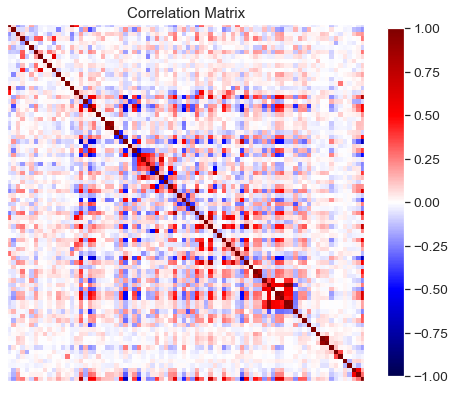

In [ ]:
plot_corr(x_train.join(y_train))

The user selects a level of correlation to cut-off; meaning that anything between this percentage will be considered as uncorrelated. For instance, a corr_bound=0.7 means that anything between -0.7-to-0.7 is considered uncorrelated to SalePrice, while anything greater than 0.7 or less tha -0.7 is considered correlated. We further explore these correlated features to the target variables in different ways.

In [ ]:
#View features that have a +/- correlation greater than the user-specified corrrelation bound (corr_bound)
corr_bound = 0.6
corr_dat = (x_train.iloc[:, corr_vec<-corr_bound]).join(x_train.iloc[:, corr_vec>corr_bound])
corr_dat

,ExterQual,KitchenQual,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea
0,2,2,7,856,856,1710,2,548
1,3,3,6,1262,1262,1262,2,460
2,2,2,7,920,920,1786,2,608
3,3,2,7,756,961,1717,3,642
4,2,2,8,1145,1145,2198,3,836
...,...,...,...,...,...,...,...,...
1455,3,3,6,953,953,1647,2,460
1456,3,3,6,1542,2073,2073,2,500
1457,1,2,7,1152,1188,2340,1,252
1458,3,2,5,1078,1078,1078,1,240


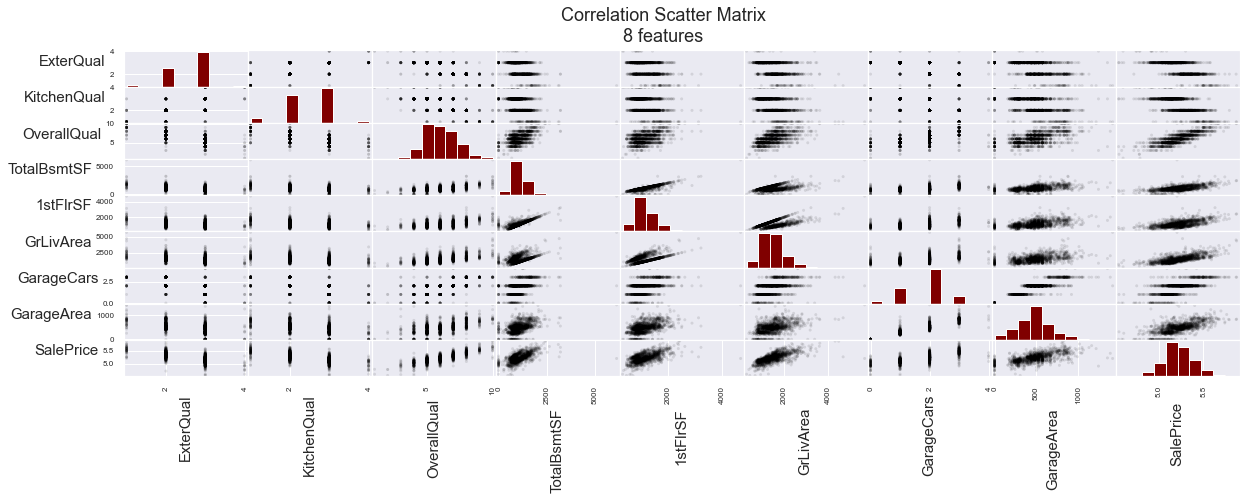

In [ ]:
axes = pd_plot.scatter_matrix(corr_dat.join(np.log10(y_train)), alpha=0.1, figsize=(20, 6), 
                              color='black', hist_kwds={'color':['maroon']})
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Correlation Scatter Matrix\n{} features'.format(corr_dat.shape[-1]))
plt.show();

In [ ]:
#full training set basic statistics
x_train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,6.126712,57.623288,10516.828082,1.995890,0.090411,1.408219,1.185616,1.001370,1.416438,...,15.060959,2.758904,0.010959,0.396575,0.144521,43.489041,6.321918,2007.815753,1.490411,1.582192
std,42.300571,1.050330,34.664304,9981.264932,0.063996,0.372151,0.582296,0.606509,0.052342,0.773448,...,55.757415,40.177307,0.177224,0.875914,0.742569,496.123024,2.703626,1.328095,1.368616,1.475209
min,20.000000,2.000000,0.000000,1300.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1.000000,1.000000
25%,20.000000,6.000000,42.000000,7553.500000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,1.000000,1.000000
50%,50.000000,6.000000,63.000000,9478.500000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,1.000000,1.000000
75%,70.000000,6.000000,79.000000,11601.500000,2.000000,0.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,1.000000
max,190.000000,8.000000,313.000000,215245.000000,2.000000,2.000000,4.000000,4.000000,3.000000,5.000000,...,480.000000,738.000000,4.000000,4.000000,5.000000,15500.000000,12.000000,2010.000000,10.000000,6.000000


In [ ]:
#main features (based on correlation coefficient) basic statistics
corr_dat.describe()

,ExterQual,KitchenQual,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea
count,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2.60411,2.488356,6.099315,1057.429452,1162.626712,1515.463699,1.767123,472.980137
std,0.57428,0.663760,1.382997,438.705324,386.587738,525.480383,0.747315,213.804841
min,1.00000,1.000000,1.000000,0.000000,334.000000,334.000000,0.000000,0.000000
25%,2.00000,2.000000,5.000000,795.750000,882.000000,1129.500000,1.000000,334.500000
50%,3.00000,3.000000,6.000000,991.500000,1087.000000,1464.000000,2.000000,480.000000
75%,3.00000,3.000000,7.000000,1298.250000,1391.250000,1776.750000,2.000000,576.000000
max,4.00000,4.000000,10.000000,6110.000000,4692.000000,5642.000000,4.000000,1418.000000


With these N correlated features, we now explore how the strong is the correlation with the SalePrice target variable. We observe the numerical value, as well as the boxplot behavior of these highly-correlated features.

In [ ]:
corr_dat.join(y_train).corr()['SalePrice']

ExterQual     -0.682639
KitchenQual   -0.659600
OverallQual    0.790982
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

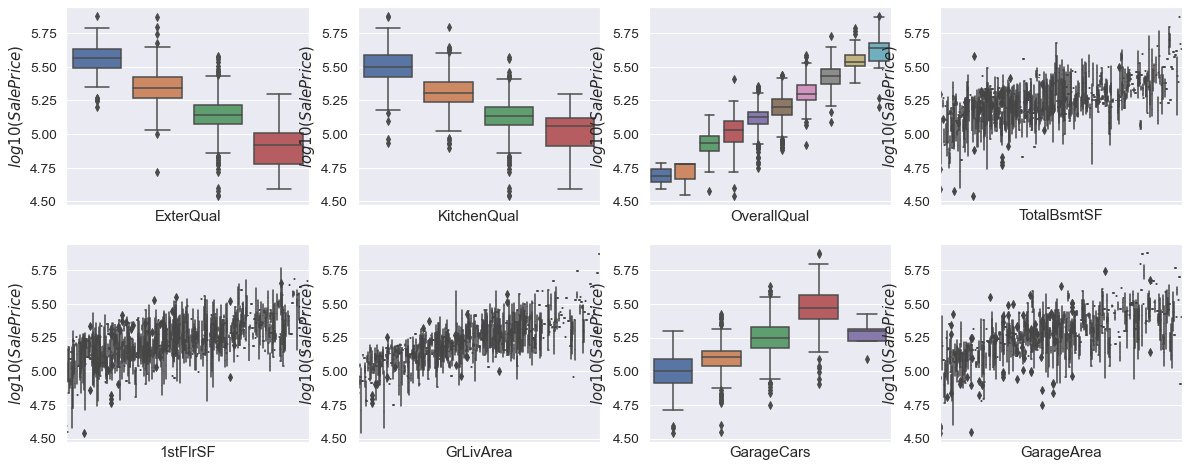

In [ ]:
plt.figure(figsize=(20,corr_dat.shape[-1]))
for k in np.arange(corr_dat.shape[-1]):
    plt.subplot(corr_dat.shape[-1]//4,4,k+1)
    sns.boxplot(x=corr_dat.iloc[:,k], y=np.log10(y_train))
    plt.xticks([]); plt.ylabel('$log10(SalePrice)$')
plt.show();

We also visualize the target variable, <u>SalePrice</u>. We notice that these values are log-normally distributed. There are a very small amount of extremely expensive houses, while the vast majority are closer to the average. Therefore, taking the logarithm of this will make them Normally distributed. This will help a lot for the regression techniques, and therefore we will be working with the natural log of SalePrice from now on. 

In [ ]:
target = np.log10(y_train)
print('       SalePrice: Mean {:.3e} | Std. Dev {:.3e}'.format(y_train.mean(), y_train.std()))
print('Log10(SalePrice): Mean {:.3f}     | Std. Dev {:.3f}'.format(target.mean(), target.std()))

       SalePrice: Mean 1.809e+05 | Std. Dev 7.944e+04
Log10(SalePrice): Mean 5.222     | Std. Dev 0.173


In [ ]:
print('       SalePrice: Skewness={:.3f} | Kurtosis={:.3f}'.format(y_train.skew(), y_train.kurt()))
print('Log10(SalePrice): Skewness={:.3f} | Kurtosis={:.3f}'.format(target.skew(), target.kurt()))

       SalePrice: Skewness=1.883 | Kurtosis=6.536
Log10(SalePrice): Skewness=0.121 | Kurtosis=0.810


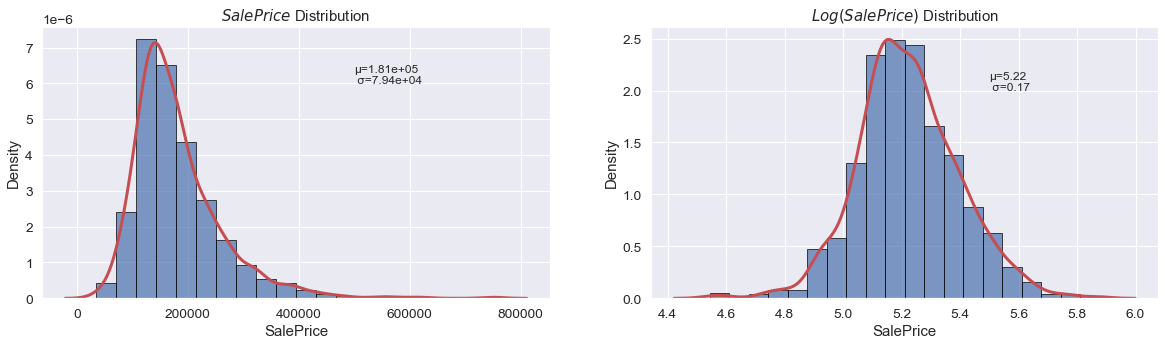

In [ ]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(121)
plt.title('$SalePrice$ Distribution')
ax1.text(5E5,6E-6, 'μ={:.2e}\n σ={:.2e}'.format(y_train.mean(), y_train.std()), fontsize=12)
plt.hist(y_train, density=True, bins=20, alpha=0.7, histtype='bar', ec='black')
sns.kdeplot(y_train, linewidth=3, c='r')

ax2 = plt.subplot(122)
plt.title('$Log(SalePrice)$ Distribution')
ax2.text(5.5, 2, 'μ={:.2f}\n σ={:.2f}'.format(target.mean(), target.std()), fontsize=12)
plt.hist(target, density=True, bins=20, alpha=0.7, histtype='bar', ec='black')
sns.kdeplot(target, linewidth=3, c='r')

plt.show();

On a slightly different note, we will plot the relationship between two variables at a time and the target log10(SalePrice), using Seaborn, and try to fit a linear regressor onto the data. This will test for linearity and for possible colinearity, and will also compute the $r^2$ coefficient and $p$ value for the regression estimate.

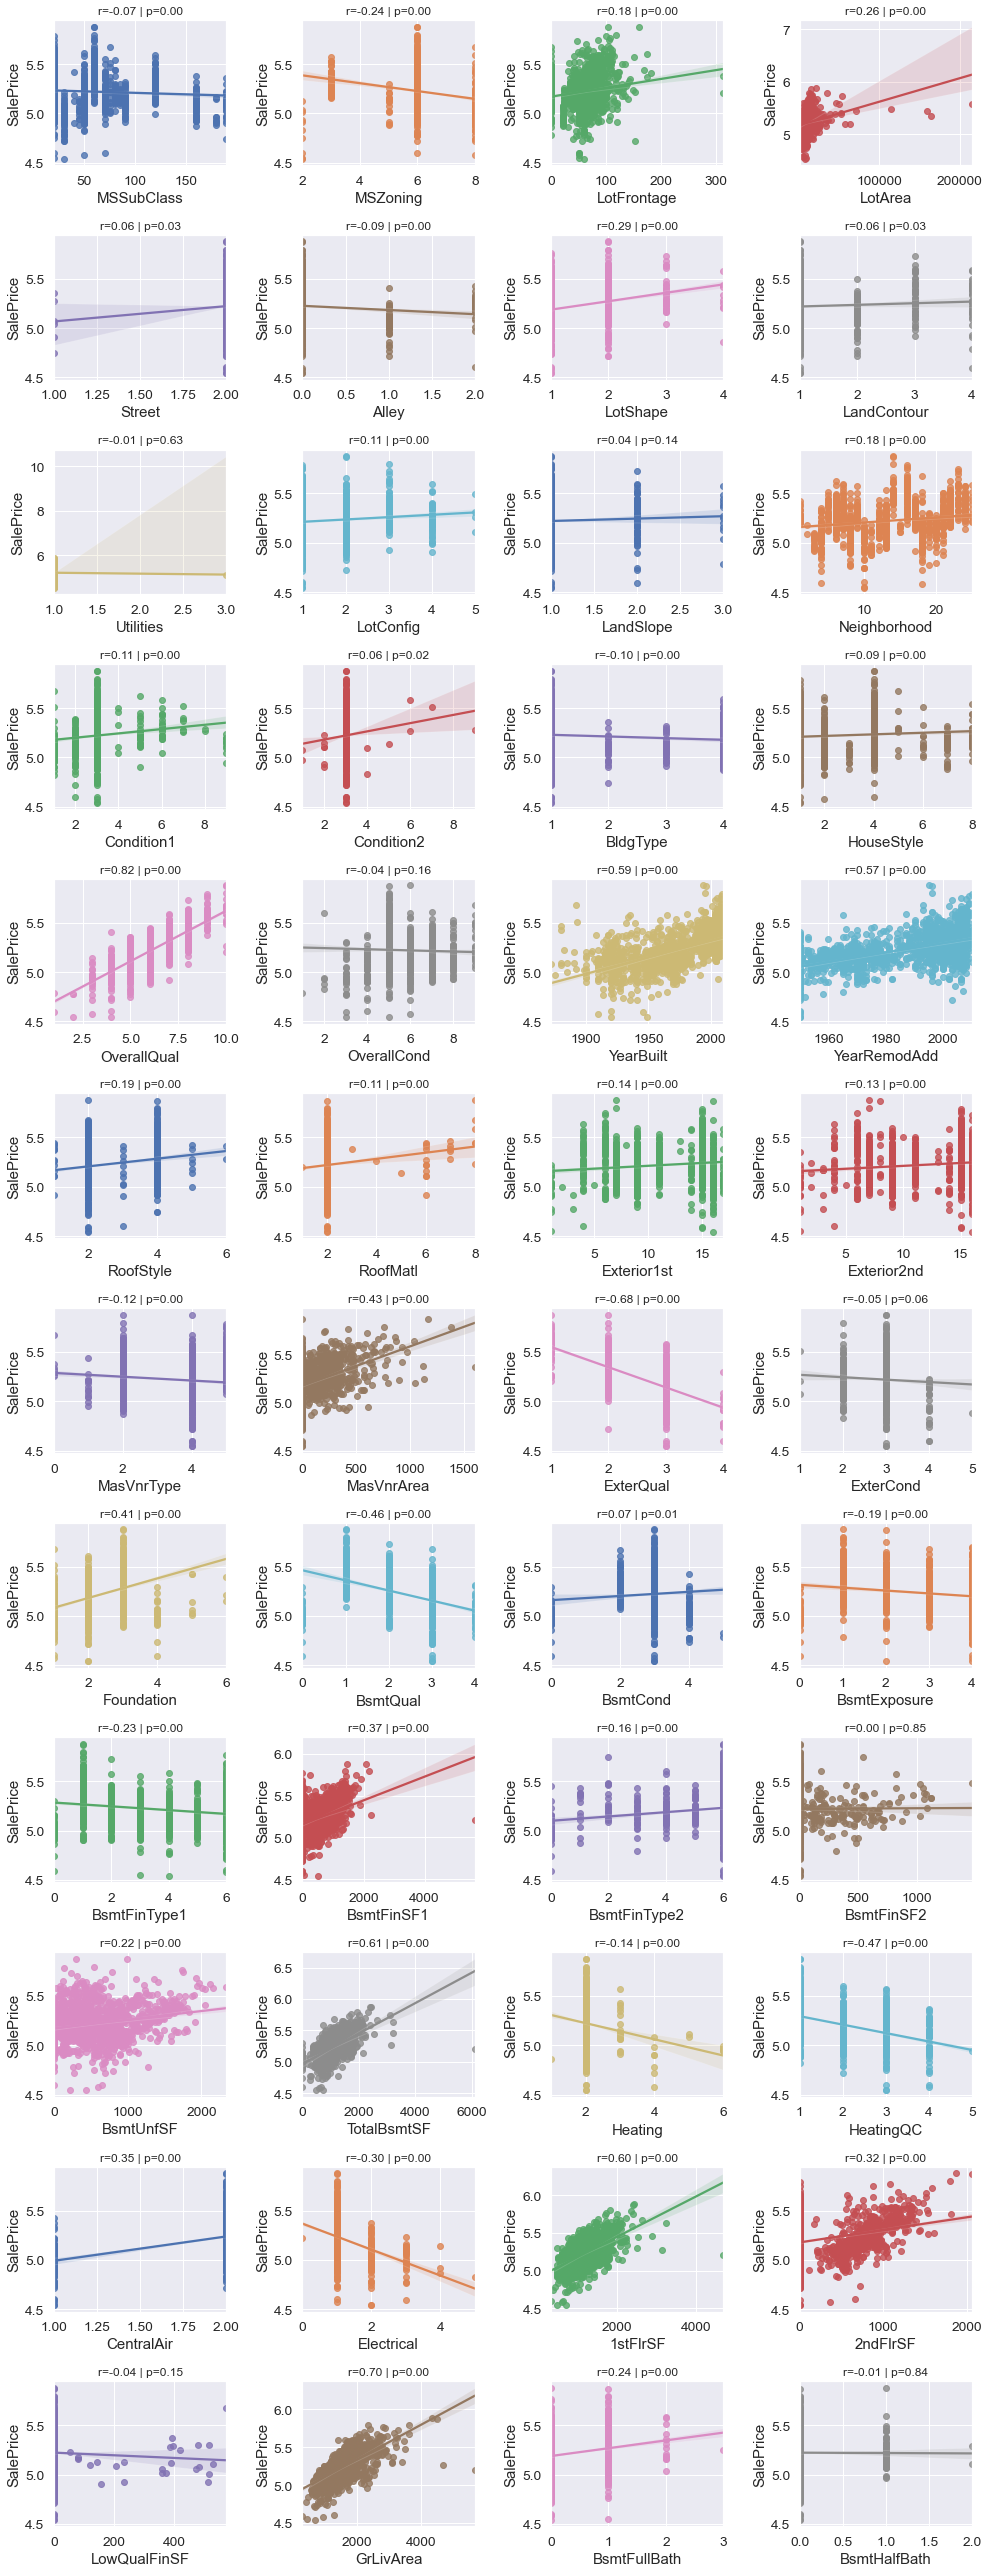

In [ ]:
nr_rows, nr_cols = 12, 4
colors = sns.color_palette()

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=x_train[li_plot_num_feats[i]], y=target, 
                        ax = axs[r][c], color=colors[i % 10])
            stp = stats.pearsonr(x_train[li_plot_num_feats[i]], target)
            str_title = "r="+"{0:.2f}".format(stp[0])+" | "+"p="+"{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=12)
            
plt.tight_layout()    
plt.show()

***

# 4. Exploratory Data Analysis

After understanding the data statistics and relationships, we will now try to do some basic data analytics on the preprocessed data.

In [ ]:
def plot_corr_matrix(df, nr_c, targ) :
    corr_abs = df.corr().abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    plt.figure(figsize=(nr_c, nr_c))
    plt.title('Correlation Matrix')
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, cbar_kws={'shrink':0.8},
                yticklabels=cols.values, xticklabels=cols.values)
    plt.show();

In [ ]:
print('Significant Correlation Bound: ', corr_bound)
print('Shape of training data above correlation bound: ', corr_dat.shape)

Significant Correlation Bound:  0.6
Shape of training data above correlation bound:  (1460, 8)


In [ ]:
target_name = 'SalePrice'

corr_abs = train_df.corr().abs()
ser_corr = corr_abs.nlargest(len(numerical_feats), target_name)[target_name]

cols_abv_corr_limit = list(ser_corr[ser_corr.values >= corr_bound].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values < corr_bound].index)

nr_feats = len(cols_abv_corr_limit)

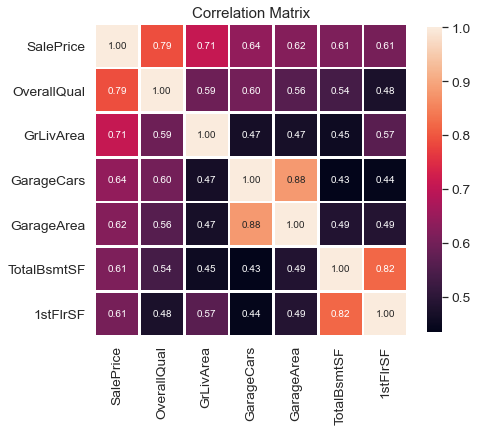

In [ ]:
plot_corr_matrix(train_df, nr_feats, target_name)

From the covariance matrix, we see that for some features like 'OverallQual' there is a strong linear correlation (0.8 approximately) to the target. For other features like 'MSSubClass' or 'MiscFeature' the correlation is very weak.

Scale the correlation-based data so that all features values are between 0 and 1. This will help greatly for the regression modeling and the visualization and interpretation of the models and the data.

In [ ]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(corr_dat)

Perform <u>PCA</u> to encode the correlation-based data into orthogonal singular vectors that will best describe the variability of the data. This will help visualize and try and classify clusters of data based on these new principal directions.

In [ ]:
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(x_train_s)

#variance explained by each PC
print('PC Variance Explained: {}'.format(pca.explained_variance_ratio_))
print('Cumulative Variance Explained: {}'.format(np.sum(pca.explained_variance_ratio_).round(4)))

PC Variance Explained: [0.59394484 0.12746352 0.10382664 0.07290565]
Cumulative Variance Explained: 0.8981


We see that with 4 PC's, for instance, we can explain approximately 90% of the variance in the scaled, clean data set.

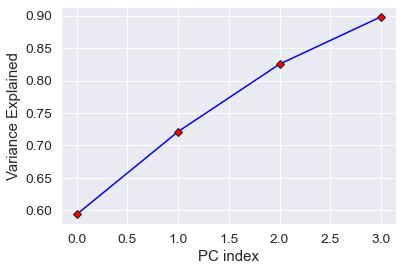

In [ ]:
#plot n_PC-vs-varExplained
plt.figure()
plt.plot(range(len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_), 
         '-bD',  c='blue', mfc='red', mec='k')
plt.xlabel('PC index')
plt.ylabel('Variance Explained')
plt.grid('on')
plt.show();

We can see that PC1 and PC3 help us find a slight classification in PC-space for the categorical variables 'ExterQual', 'KitchenQual', 'OverallQual', and 'GarageCars'; especially the last one. 

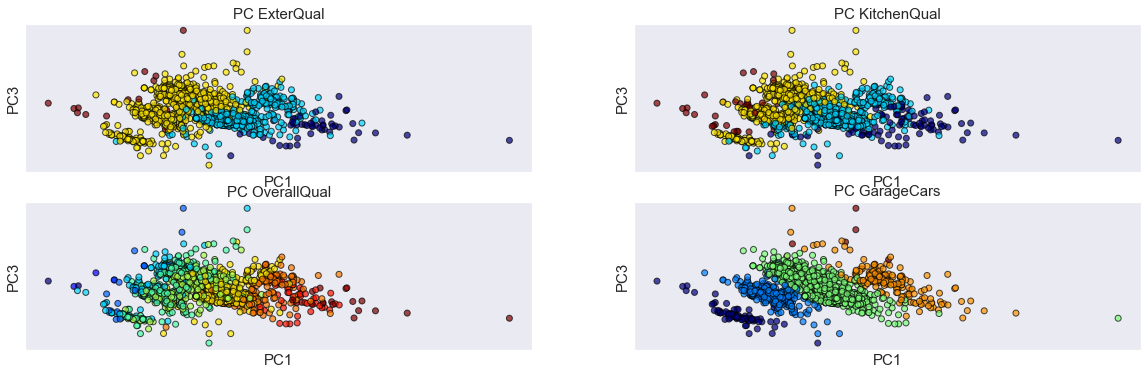

In [ ]:
x_trans = pca.transform(x_train_s)  

plt.figure(figsize=(20,6))
plt.subplot(221)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['ExterQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC ExterQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(222)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['KitchenQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC KitchenQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(223)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['OverallQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC OverallQual'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.subplot(224)
plt.scatter(x_trans[:,0], x_trans[:,2], c=corr_dat['GarageCars'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC GarageCars'); plt.xlabel('PC1'); plt.ylabel('PC3'); plt.xticks([]); plt.yticks([])
plt.show();

On the other hand, we can perform t-distributed Stochastic Neighbor Embedding (TSNE), which converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. Here, we can see a good separation for 'ExterQual' and 'GarageCars' features, proving useful for predicting sale price using these variables.

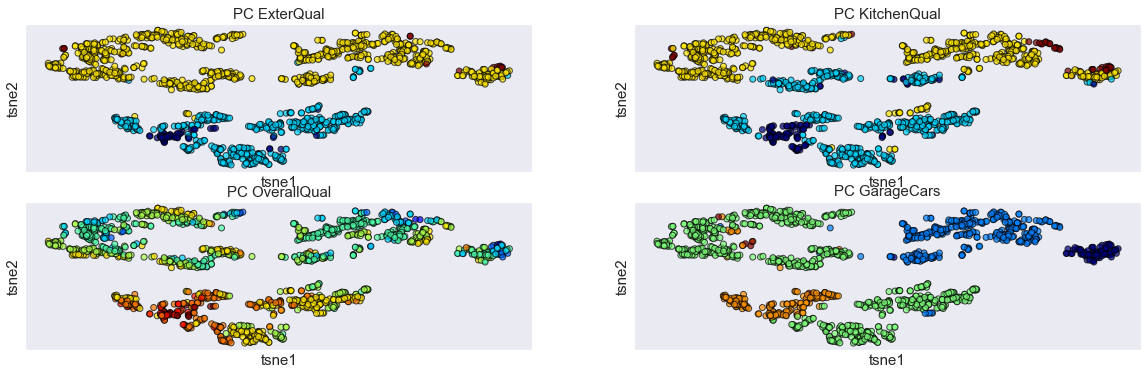

In [ ]:
tsne = TSNE(n_components = 2).fit_transform(x_train_s)

plt.figure(figsize=(20,6))
plt.subplot(221)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['ExterQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC ExterQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(222)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['KitchenQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC KitchenQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(223)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['OverallQual'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC OverallQual'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.subplot(224)
plt.scatter(tsne[:,0], tsne[:,1], c=corr_dat['GarageCars'], cmap='jet', edgecolors="black", alpha=0.7)
plt.title('PC GarageCars'); plt.xlabel('tsne1'); plt.ylabel('tsne2'); plt.xticks([]); plt.yticks([])
plt.show();

Next, we use <u>K-Means Clustering </u> and <u> Hierarchical Clustering </u> to try and find some relationships in the data. This algorihtm is unsupervised, and therefore tries to cluster the data based on similar predictor values toward the target. This will allow us to observe how we can start classifying and relating the data to the SalePrice. Using 3 clusters we might be able to visualize high/medium/low price houses based on these different highly-correlated predcitor features.

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(X=x_train_s, y=target).labels_
hclust = AgglomerativeClustering(n_clusters = n_clusters).fit(X=x_train_s, y=target).labels_
gmm    = GaussianMixture(n_components=n_clusters).fit_predict(X=x_train_s, y=target)

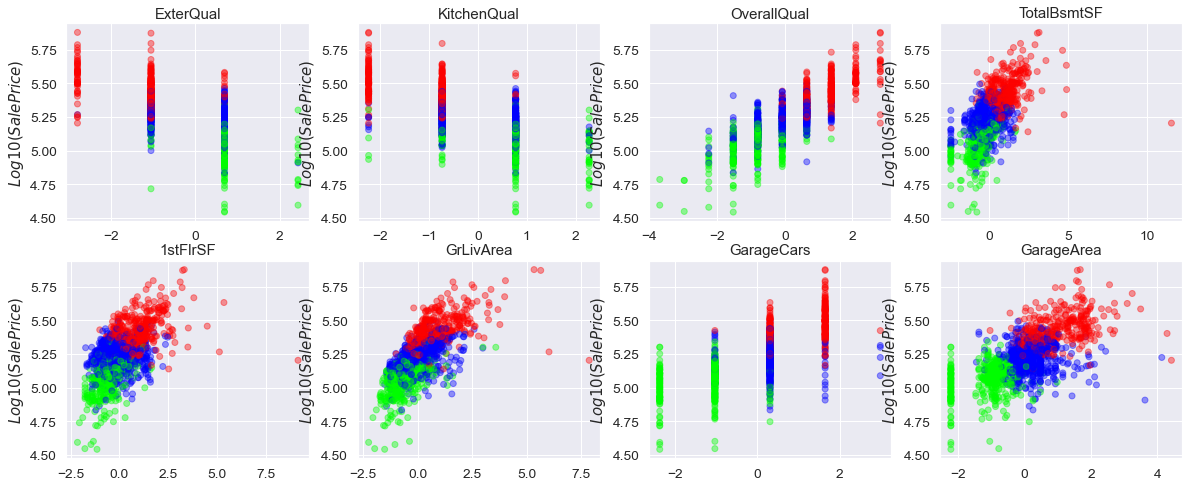

In [ ]:
#select the clustering method to visualize
clust_method = kmeans 

plt.figure(figsize=(20,8))
for k in range(len(corr_dat.columns)):
    plt.subplot(x_train_s.shape[-1]//4,4,k+1)
    plt.title('{}'.format(corr_dat.columns[k]))
    plt.scatter(x_train_s[:,k], target, c=clust_method, cmap='brg', alpha=0.4)
    plt.ylabel('$Log10(SalePrice)$')
plt.show();

We now perform <u> Local Outlier Factor </u> analysis to try and see if we can find any major outliers in the highly-correlated subset of the data. 

In [ ]:
lof = LocalOutlierFactor(n_neighbors=5)
lof.fit_predict(X=x_train_s, y=target)
lof_factors = -lof.negative_outlier_factor_
print('Local Outlier Factors: {}'.format(lof_factors)) #outliers are further away from 1

# let outliers be those that are more than this upper bound value
lof_outliers_bound = 5

Local Outlier Factors: [0.9848064  0.97417749 1.10287748 ... 2.64963468 0.95880616 1.08014456]


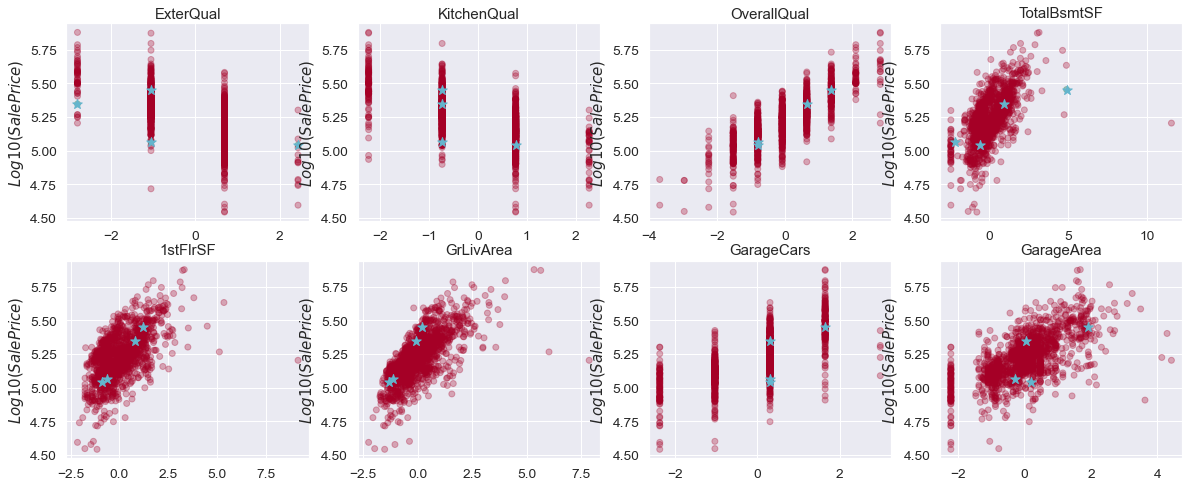

In [ ]:
plt.figure(figsize=(20,8))
for k in range(len(corr_dat.columns)):
    plt.subplot(x_train_s.shape[-1]//4,4,k+1)
    plt.title('{}'.format(corr_dat.columns[k]))
    plt.scatter(x_train_s[:,k], target, c=lof_factors>lof_outliers_bound, cmap='RdYlGn', alpha=0.3)
    plt.scatter(x_train_s[:,k][lof_factors>lof_outliers_bound], target[lof_factors>lof_outliers_bound], 
                c='c', alpha=1, marker="*", s=100)
    plt.ylabel('$Log10(SalePrice)$')
plt.show();

***

<h1> Concluding Remarks: </h1>

- <u> Remarks </u><br>
    * The data has a different types of predictor features, including categorical and numerical. We mapped all categorical features into classes, which can then be used for supervised learning techniques.
    * The target variables, SalePrice, is log-normally distributed and thus any regression algorithms should be predicting the log10(SalePrice) pseudofeature instead.
    * Data preprocessing and analysis included statistical and visual analysis; as well as unsupervised learning, also known as clustering analysis.
    * Some outliers are still present in the data, though they are only but a small percentage of the instances in the highly-correlated features selected.


- <u> Conclusion </u><br>
    * The Ames Housing data set is a complex yet versatile data set from machine learning projects. 
    * Preprocessing and data wrangling is crucial for explointing the full potential of all features.
    * The data is now ready to be used in different regression models to predict SalePrice from the features.
    

- <u> Part 2: Regression </u><br>
We will attempt to use 6 different regression algorithms on the preprocessed data set. These potentially include linear regression, regularized regression, boosting, SVM, random forest, and neural networks. We will then compare the performance of the differnet algorithms in predicting the (logarithm) SalePrice using the (subset) 79 (preprocessed) predictors provided. The mean-squared error metric will be used for optimization, and we hope to produce very accurate and itneresting predictive models for the Ames Housing dataset.

***

# 5. REGRESSION MODELING

We start by clearly defining the training ("train") and testing ("test") data set. The training data set comes from our data preprocessing, where we selected the features with the highest correlation and therefore the most relevant to the regression modeling. We will use these main features to predict the (log10) SalePrice ("target") of the Housing dataset from the test set.

In [ ]:
train = corr_dat 
test  = x_test[corr_dat.columns].append(corr_dat.iloc[[-1]])

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Target Shape:", target.shape)

Train Shape: (1460, 8)
Test Shape: (1460, 8)
Target Shape: (1460,)


In [ ]:
# recall original test ID for Kaggle submissions
id_test = test_df['Id']

## Comparing our Models

While we used several metrics to understand the performance of our models, for the purpose of presenting a consistent metric, we will compute the cvrmse on every model. 

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, random_state=21, shuffle=True)

RMSE_map = {}

def cv_rmse(model, x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, target, scoring="neg_mean_squared_error", cv=kf))
    return (rmse.mean(), rmse.std())

## 2a. Linear Regression

We build a simple linear regression to predict SalePrice as a function of a linear combination of the highly-correlated features in the dataset.
Following that, we use this linear model to predict the test set, and compute the resulting MSE.

Linear Regression R^2 coefficient: 0.8072
Linear Regression MSE: 0.05413


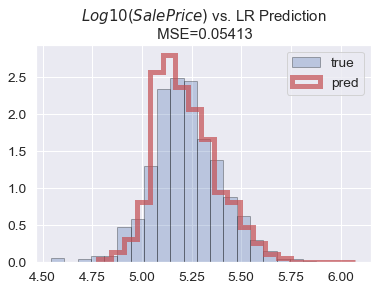

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True).fit(train,target)
print('Linear Regression R^2 coefficient: %.4f' %reg.score(train,target))

y_LR = reg.predict(test)
mse_LR = mean_squared_error(target,y_LR)
print("Linear Regression MSE:", np.round(mse_LR,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. LR Prediction\n MSE={}'.format(np.round(mse_LR,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_LR, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

We see that linear regression proves to be a sufficient algorithm to predict the SalePrice; however, further regularization can help with overfitting/underfitting issues. Moreover, cross-validation can also help in finding the best regularization parameters to predict the target.

In [ ]:
rmse = cv_rmse(reg, train)

RMSE_map['linear_reg'] = rmse
print('Linear Regression: {:.4f} ({:.4f})'.format(*rmse))

Linear Regression: 0.0770 (0.0110)


In [ ]:
pred_y_LR = pd.DataFrame()
pred_y_LR['Id'] = test_df['Id']
pred_y_LR['SalePrice'] = 10**y_LR[:-1]
pred_y_LR.to_csv('submission_StochasticResults_linreg.csv',index=False)

## 2b. Regularized Regression

Adding onto the linear regression, we use Ridge, Lasso, and ElasticNet regression to predict our SalePrice target, and compare the resulting MSE. <br>
To all of these methods, we apply the automatic Cross-Validation algorithm from sklearn.
* Ridge regression, also known as Tikhonov regularization, applies and l2 penalty to the linear regression to reduce large deviations. 
* Lasso regression, also known as shrinkage, sparsifies the model and reduces small values to 0 to try and improve the prediction. 
* ElasticNet regression is the combination of Ridge and Lasso penalty terms into a single regularized linear regression model. <br>


Ridge Regression R^2 coefficient: 0.8072
Ridge Regression MSE: 0.05404


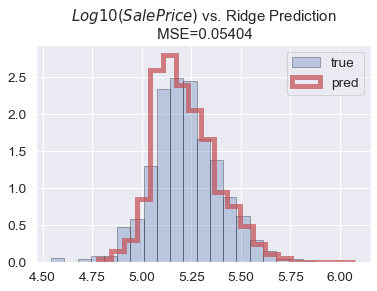

In [ ]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge = RidgeCV().fit(train,target)
print('Ridge Regression R^2 coefficient: %.4f' %ridge.score(train,target))

y_ridge = ridge.predict(test)
mse_ridge = mean_squared_error(target, y_ridge)
print("Ridge Regression MSE:", np.round(mse_ridge,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. Ridge Prediction\n MSE={}'.format(np.round(mse_ridge,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_ridge, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(ridge, train)

RMSE_map['ridge'] = rmse
print('Ridge: {:.4f} ({:.4f})'.format(*rmse))

Ridge: 0.0771 (0.0111)


In [ ]:
pred_y_ridge = pd.DataFrame()
pred_y_ridge['Id'] = test_df['Id']
pred_y_ridge['SalePrice'] = 10**y_ridge[:-1]
pred_y_ridge.to_csv('submission_StochasticResults_ridge.csv',index=False)

Lasso Regression R^2 coefficient: 0.6721
Lasso Regression MSE: 0.04815


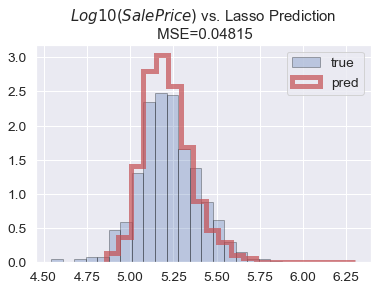

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV().fit(train,target)
print('Lasso Regression R^2 coefficient: %.4f' %lasso.score(train,target))

y_lasso = lasso.predict(test)
mse_lasso = mean_squared_error(target,y_lasso )
print("Lasso Regression MSE:", np.round(mse_lasso,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. Lasso Prediction\n MSE={}'.format(np.round(mse_lasso,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_lasso, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(lasso, train)

RMSE_map['lasso'] = rmse
print('Lasso: {:.4f} ({:.4f})'.format(*rmse))

Lasso: 0.1003 (0.0141)


In [ ]:
pred_y_lasso = pd.DataFrame()
pred_y_lasso['Id'] = test_df['Id']
pred_y_lasso['SalePrice'] = 10**y_lasso[:-1]
pred_y_lasso.to_csv('submission_StochasticResults_lasso.csv',index=False)

ElasticNet Regression R^2 coefficient: 0.6721
ElasticNet Regression MSE: 0.04815


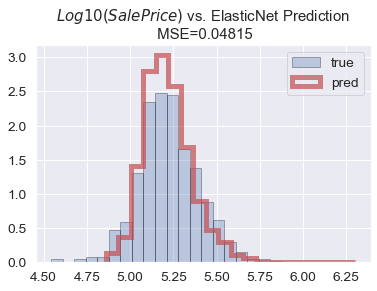

In [ ]:
from sklearn.linear_model import ElasticNetCV
elastic = ElasticNetCV().fit(train,target)
print('ElasticNet Regression R^2 coefficient: %.4f' %elastic.score(train,target))

y_elastic = elastic.predict(test)
mse_elastic = mean_squared_error(target,y_elastic)
print("ElasticNet Regression MSE:", np.round(mse_elastic,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. ElasticNet Prediction\n MSE={}'.format(np.round(mse_elastic,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_elastic, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(elastic, train)

RMSE_map['elastic'] = rmse
print('Elastic: {:.4f} ({:.4f})'.format(*rmse))

Elastic: 0.1003 (0.0141)


In [ ]:
pred_y_elastic = pd.DataFrame()
pred_y_elastic['Id'] = test_df['Id']
pred_y_elastic['SalePrice'] = 10**y_elastic[:-1]
pred_y_elastic.to_csv('submission_StochasticResults_elastic.csv',index=False)

With Cross-Validated regularized regression, we see a good improvement from the simple linear regression. These techniques further exploit the most relevant features in predicting the target variables by shrinking or putting less weight on the less-correlated features. Here, we have used Leave-One-Out Cross-Validation (LOOCV) in order to find the best hyperparameters for the regularization terms in the regression models.

## 2c. Boosting

Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

Gradient Boosting Regression R^2 coefficient: 0.9015
Gradient Boosting Regression MSE: 0.05624


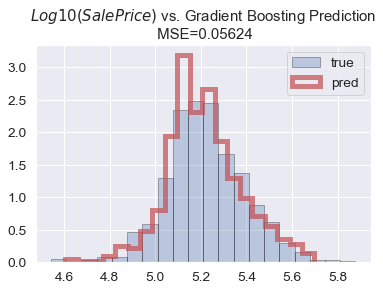

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
boost = GradientBoostingRegressor().fit(train,target)
print('Gradient Boosting Regression R^2 coefficient: %.4f' %boost.score(train,target))

y_boost = boost.predict(test)
mse_boost = mean_squared_error(target,y_boost)
print("Gradient Boosting Regression MSE:", np.round(mse_boost,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. Gradient Boosting Prediction\n MSE={}'.format(np.round(mse_boost,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_boost, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(boost, train)

RMSE_map['boost'] = rmse
print('Boost: {:.4f} ({:.4f})'.format(*rmse))

Boost: 0.0698 (0.0034)


In [ ]:
pred_y_boost = pd.DataFrame()
pred_y_boost['Id'] = test_df['Id']
pred_y_boost['SalePrice'] = 10**y_boost[:-1]
pred_y_boost.to_csv('submission_StochasticResults_boost.csv',index=False)

## 2e. Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. <br> This technique will help significantly with overfitting issues by using an ensemble of weak-learner to predict the target variable from the features.

Random Forest Regression R^2 coefficient: 0.9745
Random Forest Regression MSE: 0.05606


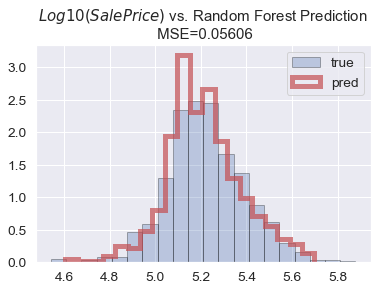

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(train,target)
print('Random Forest Regression R^2 coefficient: %.4f' %rf.score(train,target))

y_rf = rf.predict(test)
mse_rf = mean_squared_error(target,y_rf)
print("Random Forest Regression MSE:", np.round(mse_rf,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. Random Forest Prediction\n MSE={}'.format(np.round(mse_rf,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_boost, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(rf, train)

RMSE_map['rf'] = rmse
print('RF: {:.4f} ({:.4f})'.format(*rmse))

RF: 0.0742 (0.0045)


In [ ]:
pred_y_rf = pd.DataFrame()
pred_y_rf['Id'] = test_df['Id']
pred_y_rf['SalePrice'] = 10**y_rf[:-1]
pred_y_rf.to_csv('submission_StochasticResults_rf.csv',index=False)

## 2d. Support Vector Machines

We implement support vector machines as a regression algorithm in two ways: i) with linear kernels, ii) with radial-basis-function (gaussian) kernel. The first will help compare more closely to our previously implemented linear regression models, while the second will produce an improved support vector regressor for the given features and the target variable. We ensure to standard-scale the data so that the kernels are equivalent, and use slack variables and tolerances for the optimization algorithm to converge properly.

Linear Support Vector Regression R^2 coefficient: 0.7345
RBF Support Vector Regression R^2 coefficient: 0.6896


Linear Support Vector Regression MSE: 0.05938
RBF Support Vector Regression MSE: 0.05624


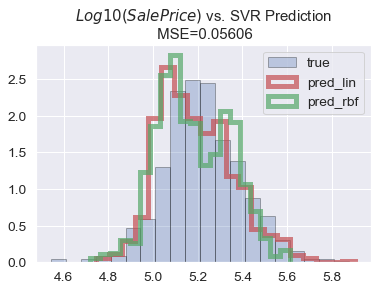

In [ ]:
from sklearn.svm import SVR
svm_linear = make_pipeline(StandardScaler(), SVR(kernel='linear',C=1.0, epsilon=0.2)).fit(train,target)
svm_rbf    = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1.0, epsilon=0.2)).fit(train,target)
print('Linear Support Vector Regression R^2 coefficient: %.4f' %svm_linear.score(train,target))
print('RBF Support Vector Regression R^2 coefficient: %.4f' %svm_rbf.score(train,target))
print('\n')

y_svm_linear = svm_linear.predict(test)
y_svm_rbf = svm_rbf.predict(test)
mse_svm_linear = mean_squared_error(target,y_svm_linear)
mse_svm_rbf = mean_squared_error(target,y_svm_rbf)
print("Linear Support Vector Regression MSE:", np.round(mse_svm_linear,5))
print("RBF Support Vector Regression MSE:", np.round(mse_svm_rbf,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. SVR Prediction\n MSE={}'.format(np.round(mse_rf,5)))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_svm_linear, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred_lin')
plt.hist(y_svm_rbf, density=True, bins=20, alpha=0.7, histtype='step', color='g', linewidth=5, label='pred_rbf')
plt.legend()
plt.show();

In [ ]:
rmse = cv_rmse(svm_linear, train)

RMSE_map['svm_linear'] = rmse
print('SVM Linear: {:.4f} ({:.4f})'.format(*rmse))

SVM Linear: 0.0938 (0.0053)


In [ ]:
rmse = cv_rmse(svm_rbf, train)

RMSE_map['svm_rbf'] = rmse
print('SVM RBF: {:.4f} ({:.4f})'.format(*rmse))

SVM RBF: 0.1003 (0.0049)


In [ ]:
pred_y_svm_linear = pd.DataFrame()
pred_y_svm_linear['Id'] = test_df['Id']
pred_y_svm_linear['SalePrice'] = 10**y_svm_linear[:-1]
pred_y_svm_linear.to_csv('submission_StochasticResults_svmlin.csv',index=False)

pred_y_rf = pd.DataFrame()
pred_y_rf['Id'] = test_df['Id']
pred_y_rf['SalePrice'] = 10**y_svm_rbf[:-1]
pred_y_rf.to_csv('submission_StochasticResults_svmrbf.csv',index=False)

## 2f. Neural Network

Neural Networks provide enhanced regression power compared to other algorithms, as they can capture the nonlinearity in the data more accurately, and provide higher flexibility in terms of the weights used for the correlation of the hidden layers and variables. Here, we use a fully-connected neural network from the high-correlated training set to the target variable. We do not need to use dropout regularization since the network is relatively simple and still able to capture the relationships between the features and predictor. We also experimented vastly with hyperparameters such as learning rate (or step size selection in the optimization algorithm), the number of epochs, and other parameters. By using a validation split in the training we also control for overfitting, and by selecting the best number of epochs we avoid overfitting as well.

In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Layer, Dense, Dropout

from keras import backend as K
from keras.engine.base_layer import InputSpec

from IPython.display import clear_output
from keras.callbacks import History 

In [ ]:
#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('(log)loss')
        plt.legend()
        plt.show()    

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=train.shape[-1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


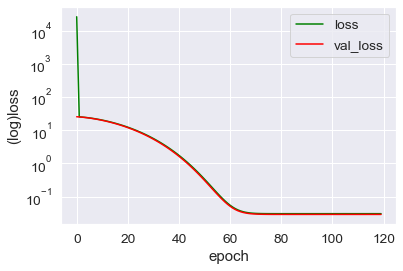


73/73 [==============================] - 0s 6ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0289 - val_mse: 0.0289


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
model.fit(train,target,
         epochs=120,
         batch_size=16,
         shuffle=True,
         validation_split=0.2,
         callbacks=[PlotLosses()])

Neural Network Regression MSE: 0.03008


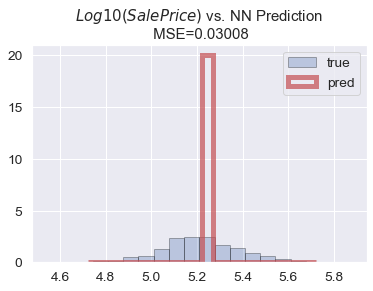

In [ ]:
y_NN  = model.predict(test).flatten()
mse_NN = mean_squared_error(target,y_NN)
print("Neural Network Regression MSE:", np.round(mse_NN,5))

plt.figure()
plt.title('$Log10(SalePrice)$ vs. NN Prediction\n MSE={:.5f}'.format(mse_NN))
plt.hist(target, density=True, bins=20, alpha=0.3, histtype='bar', ec='black', label='true')
plt.hist(y_NN, density=True, bins=20, alpha=0.7, histtype='step', color='r', linewidth=5, label='pred')
plt.legend()
plt.show();

In [ ]:
pred_y_NN = pd.DataFrame()
pred_y_NN['Id'] = test_df['Id']
pred_y_NN['SalePrice'] = 10**y_NN[:-1]
pred_y_NN.to_csv('submission_StochasticResults_NN.csv',index=False)

In [ ]:
# Clear Keras sessions
# this will remove current weights and hyperparameters from the trained layers, in case we want to re-run from scratch
K.clear_session()

### Compare all regression models

In [ ]:
preds = {'Linear':y_LR, 'Ridge':y_ridge, 'Lasso':y_lasso, 'ElasticNet':y_elastic, 'GradientBoost':y_boost, 
    'RandomForest':y_rf, 'SVM_linear':y_svm_linear, 'SVM_rbf':y_svm_rbf, 'NeuralNet':y_NN}

In [ ]:
for i in range(len(preds)):
    print(list(preds.keys())[i],":", np.round(mean_squared_error(target, list(preds.values())[i]),5))

Linear : 0.05413
Ridge : 0.05404
Lasso : 0.04815
ElasticNet : 0.04815
GradientBoost : 0.05624
RandomForest : 0.05606
SVM_linear : 0.05938
SVM_rbf : 0.05624
NeuralNet : 0.03008


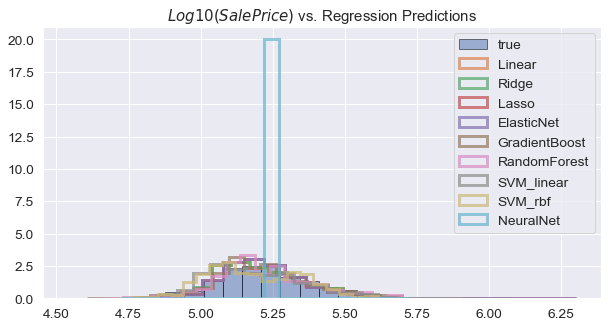

In [ ]:
plt.figure(figsize=(10,5))
plt.title('$Log10(SalePrice)$ vs. Regression Predictions')
plt.hist(target, density=True, bins=20, alpha=0.5, histtype='bar', ec='black', label='true')
for i in range(len(preds)):
    plt.hist(list(preds.values())[i], density=True, bins=20, alpha=0.7, histtype='step', linewidth=3, label=list(preds.keys())[i])
plt.legend()
plt.show();

***

<h1> Concluding Remarks: </h1>

- <u> Remarks </u><br>
    * After our data preprocessing techniques, most regression algorithms will provide good predictions for the log10(SalePrice) target variable using the most high-correlated feature variables.
    * Fully-Connected Neural Network with nonlinear activations provides really good MSE (since we are optimizing with this loss function - but simpler regression methods like regularized regression provide a better distribution of the test predictions.
    * Further sensitivity analysis and hyperparameter tuning can provide improved testing accuracy compared to the standard techniques deployed.

- <u> Conclusion </u><br>
    * The SalePrice target variable from the Ames Housing data set can be easily predicted after detailed data preprocessing and advanced regression techniques.
    * Preprocessing and data wrangling is crucial for explointing the full potential of all features.
    * Most regression algorithms will work to provide acceptable predictions. 
    * Regularization helps in further discriminating the most important predictor features.

***

# 6. Best model: Stacked Regression




In [ ]:
# Read CSV files for Train/Test datasets

train_csv = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_csv  = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

if not os.path.isfile(train_csv):
    train_csv = '../input/house-prices-advanced-regression-techniques/train.csv'
    test_csv = '../input/house-prices-advanced-regression-techniques/test.csv'
    
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

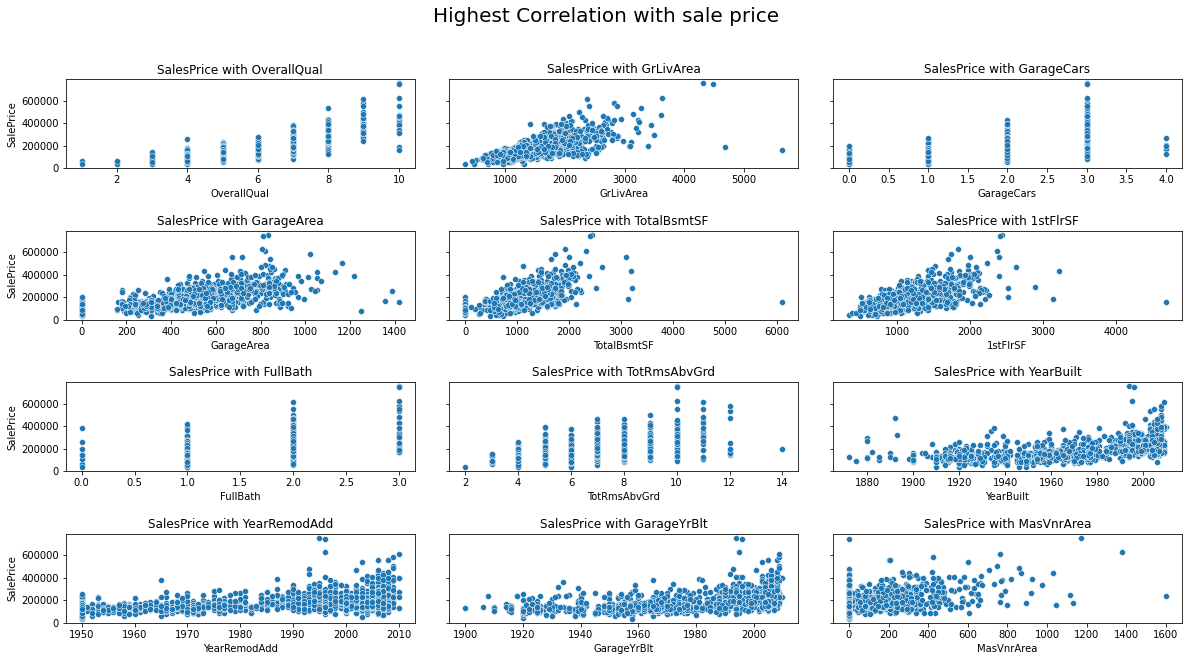

In [ ]:
# Visualize columns have corr with SalePrice
corr = train_df.corr()
high_corr = corr['SalePrice'].sort_values(ascending=False)[1:][:13].index.tolist()

fig, axes = plt.subplots(4,3, figsize=(20, 10), sharey=True);
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
fig.suptitle('Highest Correlation with sale price', fontsize=20);

for i,col in zip(range(12),high_corr):
    sns.scatterplot(y=train_df['SalePrice'], x=train_df[col], ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('SalesPrice with '+col)

In [ ]:
# Selectting the index of outliers from the scatter plots above

drop_index = train_df[((train_df['GarageArea']>1200) & (train_df['SalePrice']<300000))|
                  ((train_df['GrLivArea']>5000) & (train_df['SalePrice']<300000))|
                  ((train_df['1stFlrSF']>4000) & (train_df['SalePrice']<300000))|
                  ((train_df['TotalBsmtSF']>5000) & (train_df['SalePrice']<300000))|
                  ((train_df['MasVnrArea']>1200) & (train_df['SalePrice']<700000))|
                  ((train_df['SalePrice']>600000))].index

train_df = train_df.drop(drop_index)                  

In [ ]:
x_train = train_df.iloc[:,1:-1]  #79 train features
y_train = train_df.iloc[:,-1]    #SalePrice training target

y_train = np.log1p(y_train) 

x_test  = test_df.iloc[:,1:]     #79 test features

In [ ]:
x_train = x_train.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)
x_test  = x_test.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)

In [ ]:
all_data = pd.concat((x_train, x_test)).reset_index(drop=True)

In [ ]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features: 

There are 79 skewed numerical features to Box Cox transform


In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2910, 79)


In [ ]:
x_train = all_data[:len(x_train)]
x_test = all_data[len(x_train):]

Stacking (short for stacked generalization) is an ensemble method which uses trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble. The following figure shows such an ensemble performing a regression task on a new instance.

<img src="https://raw.githubusercontent.com/angelricardoh/MLProject/bcb6046a0beb6e535caf9051f4a0f65653772788/figure1.png"/>

Each of the bottom predictors predicts a different value and then the final predictor (called a blender or a meta learner) takes these predictions as inputs and makes the final prediction (3.0).

To avoid the tedious work to find the best hyperparameters, we used Grid Search and Randomized Search which take as an input the list of hyperparameters you want to experiment with and then uses cross-validation to evaluate all the possible combinations of hyperparameter values for the base and meta models like so:

param_grid = [
        {'n_estimators': [3, 10, 30, 100, 300, 1000, 3000], 'max_features': [2, 4, 6, 8], 'max_depth': [1, 2, 3, 4]},
]

reg = GradientBoostingRegressor()

grid_search = GridSearchCV(reg, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)
                            
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
# Define our base and meta models for stacking
base_models = (KernelRidge(),
               make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1)),
               make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9)),             
               make_pipeline(StandardScaler(),GradientBoostingRegressor(learning_rate=0.005, 
                                                                        loss='huber',
                                                                        max_depth=4, 
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=10,
                                                                        n_estimators=3000,
                                                                        random_state=1,
                                                                       )))
    
meta_model = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

To train the blender, we used a K-fold validation. If we consider initially that the training set is split into two subsets. The first subset is used to train the predictors in the first layer.

<img src="https://raw.githubusercontent.com/angelricardoh/MLProject/bcb6046a0beb6e535caf9051f4a0f65653772788/figure2.png"/>

Next, the first layer’s predictors are used to make predictions on the second set like in the previous figure. This ensures that the predictions are "clean" since the predictors never saw these instances during training. For each instance in the validation set, there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set 3D), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value, given the first layer's predictions.

<img src="https://raw.githubusercontent.com/angelricardoh/MLProject/bcb6046a0beb6e535caf9051f4a0f65653772788/figure3.png"/>

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression), to get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially.

<img src="https://raw.githubusercontent.com/angelricardoh/MLProject/bcb6046a0beb6e535caf9051f4a0f65653772788/figure4.png"/>

For the project purposes splitting our training set into 10 folds gave us the best result.

In [ ]:
# Building the stacking model
n_folds = 10
kfold = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)

stack = StackingCVRegressor(regressors=base_models,
                            meta_regressor=meta_model, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,cv=kfold,
                            random_state=1)

reg = stack.fit(x_train, y_train)

In [ ]:
reg = stack.fit(x_train, y_train)

In [ ]:
pred = np.expm1(reg.predict(x_test))
pred_train = reg.predict(x_train)
r2 = r2_score(y_train,pred_train)
rmse = np.sqrt(mean_squared_error(y_train,pred_train))
print('RMSE:',  rmse)
print('R^2:', r2_score(y_train, pred_train ))

RMSE: 0.06997731377907167
R^2: 0.9682784791672858


<h1> Concluding Remarks: </h1>

- <u> Remarks </u><br>
    * Preprocessing choice is not as important to get higher accuracy, but it is an essential step to run our models and to get acceptable predictions.
    * Using fine-tune base models is more important than adding more base models.
    * After many experiments combining and using different "simple" regression methods as base models along LGBMRegressor or XGBoosting meta-models result in the best prediction.
    * Using PCA trained data from highly correlated features or simply discarding low correlated features produced a lower RMSE we assume the model is losing important information which low correlated features are providing to our best model.
    * Fix features skewness and remove outliers proved to be relevant to produce a higher accuracy.
    * Increasing the number of folds up to 10 showed to achieve higher accuracy. Increasing the number of folds further showed no impact on accuracy.

- <u> Conclusion </u><br>
    * Fully understand the data set and different regression techniques are the capstone to get a highly accurate model.
    * Most regression algorithms provide acceptable predictions, but using the best quality of each method and stacked all predictions in a single model provided the best result for our project.

# 7. Further Experimentation

While the sections above provide a comparison of several machine learning models, in addition to an overview of our best model, we conducted much more comprehensive experiments throughout the semester. These experiments include, but are not limited to, feature engineering, feature selection, and alternative models and model compositions.



## Feature Engineering

The feature engineering implementation above is enough to convert the input csv into a form that models can train on. This is achieved by converting categorical variables into numerical variables. While this implementation clearly worked well, there is room to experiment in hopes of achieving better results.

In [ ]:
# Read CSV files for Train/Test datasets
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df  = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

x_basic_train, x_basic_test = x_train, x_test

x_train = train_df.iloc[:,1:-1]  #79 train features
y_train = train_df.iloc[:,-1]    #SalePrice training target
x_test  = test_df.iloc[:,1:]     #79 test features

In [ ]:
from collections import Counter

def most_frequent(list):
    c = Counter(list)

    return max(c.items(), key=lambda x: x[1])[0]

In [ ]:
from sklearn import preprocessing
import math

class HousePreprocessor():
    def __init__(self, useEncoder=False, useEncoderAndDummy=False, drop=True, verbose=True):
        self.verbose = verbose
        self.useEncoder = useEncoder
        self.useEncoderAndDummy = useEncoderAndDummy
        self.drop = drop
        
        
        # Declaration of mapping for specified variables (see self.relative_categories)
        rating_order_map = {'Po': 0,'Fa': 1,'TA': 2,'Gd': 3,'Ex': 4,'NA': 'NA',np.nan: 'NA'}
        basement_exposure_map = {'No': 0,'Mn': 1,'Av': 2,'Gd': 3,'NA': 'NA',np.nan: 'NA'}
        basement_finish_map = {'Unf': 0,'LwQ': 1,'Rec': 2,'BLQ': 3,'ALQ': 4,'GLQ': 5,'NA': 'NA',np.nan: 'NA'}
        functional_rating = {'Sal': 0,'Sev': 1, 'Maj2': 2,'Maj1': 3,'Mod': 4,'Min2': 5,'Min1': 6,'Typ': 7,'NA': 7,np.nan: 7}
        garage_finish_rating = {'Unf': 0,'RFn': 1,'Fin': 2,'NA': 'NA',np.nan: 'NA'}
        fence_quality_rating = {"MnWw": 0,"GdWo": 1,"MnPrv": 2,"GdPrv": 3,"NA": "NA",np.nan: 'NA'}
        bool_map = {'N': 0, 'Y': 1}
        bsmt_qual_map = {'Po': 0,'Fa': 2,'TA': 3,'Gd': 4,'Ex': 6,'NA': 'NA',np.nan: 'NA'}

        self.relative_categories = (
            [(cat, rating_order_map) for cat in ['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']] + 
            [(cat, bsmt_qual_map) for cat in ['BsmtQual']] + 
            [(cat, basement_exposure_map) for cat in ['BsmtExposure']] +
            [(cat, basement_finish_map) for cat in ['BsmtFinType1']] +
            [(cat, functional_rating) for cat in ['Functional']] +
            [(cat, garage_finish_rating) for cat in ['GarageFinish']] +
            [(cat, fence_quality_rating) for cat in ['Fence']] +
            [(cat, bool_map) for cat in ['CentralAir']]
        )
        
        # Cyclical Vars
        self.cyclical_features = ['MoSold']

        # Dummy Vars
        self.dummy_vars_to_append = ['MSSubClass']
    
    def process(self, df):
        df = df.copy()
        df = self.__manual_preprocess__(df)
        df = self.__cnvrt_relative_cats__(df)
        df = self.__cnvrt_cyclical_vars__(df)
        self.__log_remaining_category_vars__(df)
        df =  self.__add_dummy_vars__(df)
        df = self.__cnvrt_na_to_avg__(df)
        
        return df
    
    # This function adds some useful features based on our analysis of the data. 
    def __manual_preprocess__(self, df):
        # Remove NA from LotFrontage by Neighborhood
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        
        # Remove variables where the dominant attribute occurs more than 95% of the time
        toDrop = [col for col in df.columns if list(df[col]).count(most_frequent(list(df[col])))/df[col].shape[0] > 0.95]
        if self.drop:
          df = df.drop(toDrop, axis=1)
    
        # Engineer Features
        df['YearBuiltSum'] = df['YearBuilt'] + df['YearRemodAdd']  
        df['YearSinceRemodel'] = df['YearRemodAdd'] - df['YearBuilt']
        if self.drop:
          df.drop(['YearBuilt', 'YearRemodAdd'], axis=1)
        
        df['Total_Indoor_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
        if self.drop:
          df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'], axis=1)
        
        df['Num_Bathrooms'] = df['BsmtFullBath'] + df['FullBath'] 
        df['Num_Half_Bathrooms'] = df['BsmtHalfBath'] + df['HalfBath']
        if self.drop:
          df.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)
        
        df['Porch_Size'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch'] 
        if self.drop:
          df.drop(['OpenPorchSF', 'EnclosedPorch', 'ScreenPorch'], axis=1)
        
        df['hasBasement'] = df['BsmtQual'].apply(lambda x: 1 if x == 'NA' or x == np.nan else 0)
        
        return df
            
    # Using the mappings specified in __init__, this function manually maps categorical variables into integers
    def __cnvrt_relative_cats__(self, df):
        # Convert Relative Categorical into numerical
        for cat, map in self.relative_categories:
            if cat not in df:
                continue
            num_na = len([i for i in df[cat] if i is np.nan])
            df[cat] = [map[rating] for rating in df[cat]]
            cat_na = f'{cat}_NA'

            # Create Boolean NA Column
            df[cat_na] = [1 if v == 'NA' else 0 for v in df[cat]]

            # Convert NA to average 
            avg = np.average([i for i in df[cat] if i != 'NA'])
            df[cat] = [i if i != 'NA' else avg for i in df[cat]]
        return df
            
    def __cnvrt_cyclical_vars__(self, df):
        # Convert to cyclical (See for more information)
        for f in self.cyclical_features:
            norm = 2 * math.pi * df[f] / df[f].max()
            df[f'{f}_sin'] = np.sin(norm)
            df[f'{f}_cos'] = np.cos(norm)
            df.drop(f, 1)
            
        return df
            
    def __log_remaining_category_vars__(self, df):
        if self.verbose:
            # Decide which categorical variables you want to use
            for col_name in df.columns:
                if df[col_name].dtypes == 'object':
                    unique_cat = len(df[col_name].unique())
                    print(f'Feature {col_name} has {unique_cat} unique categories')
            
    # Convert remaining categorical variables into numeric form
    def __add_dummy_vars__(self, df):           
        dummy_list = [col for col in df.columns if df[col].dtypes == 'object']
        dummy_list = dummy_list + self.dummy_vars_to_append
        
        for cat in dummy_list:
          if self.useEncoderAndDummy:
            encoder = preprocessing.LabelEncoder() 
            encoder.fit(list(df[cat].values)) 
            df[f'{cat}_encoder'] = encoder.transform(list(df[cat].values))

            df[cat] =  df[cat].fillna(df[cat].mode()[0])
            dummies = pd.get_dummies(df[cat], prefix=cat, dummy_na=True)
            df = df.drop(cat, 1)
            df = pd.concat([df, dummies], axis=1)
          elif self.useEncoder:
            encoder = preprocessing.LabelEncoder() 
            encoder.fit(list(df[cat].values)) 
            df[cat] = encoder.transform(list(df[cat].values))
          else:
            df[cat] =  df[cat].fillna(df[cat].mode()[0])
            dummies = pd.get_dummies(df[cat], prefix=cat, dummy_na=True)
            df = df.drop(cat, 1)
            df = pd.concat([df, dummies], axis=1)
            
        return df
    
    # Replace remaining missing values 
    def __cnvrt_na_to_avg__(self, df):
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = list(cols_with_na[cols_with_na > 0].keys())
        
        for col in cols_with_na:
            if self.verbose:
                print(f"Converting nan's in {col} to avg of {col}")
            
            avg = np.average([i for i in df[col] if not np.isnan(i)])
            df[col] = [avg if np.isnan(i) else i for i in df[col]]
        
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = cols_with_na[cols_with_na > 0]
        assert 0 == cols_with_na.shape[0]
        
        return df     

In [ ]:
hp = HousePreprocessor(verbose=False)
x_all = pd.concat([x_train, x_test]).reset_index(drop=True)
x_all = hp.process(x_all)

hp = HousePreprocessor(useEncoder=True, verbose=False)
x_all_encoder = pd.concat([x_train, x_test]).reset_index(drop=True)
x_all_encoder = hp.process(x_all_encoder)

In [ ]:
hp_x_train = x_all.iloc[:x_train.shape[0], :]
hp_x_test = x_all.iloc[x_train.shape[0]:, :]

hp_x_train_encoder = x_all_encoder.iloc[:x_train.shape[0], :]
hp_x_test_encoder = x_all_encoder.iloc[x_train.shape[0]:, :]

print(f'Num Features using dummy variables: {hp_x_train.shape[1]}')
print(f'Num Features using label encoder: {hp_x_train_encoder.shape[1]}')

Num Features using dummy variables: 255
Num Features using label encoder: 90


The above is a more comprehensive preprocessor of the housing data. In addition to creating mappings for some categorical variables, we 


*   Engineer Custom Features
*   Drop less useful data
*   Alternate Strategies for dealing with missing data
*   Use of dummy variables (Or Label Encoders) for remaining categorical variables


In [ ]:
models = [('ridge',ridge), ('lasso',lasso), ('elastic',elastic), ('boost', boost), ('rf', rf), ('svm_linear', svm_linear), ('svm_rbf', svm_rbf),]

for name, model in models:
  rmse = cv_rmse(model, x_basic_train)

  RMSE_map[f'HP_basic_{name}'] = rmse
  print(f'Basic House Processor {name}: {rmse[0]:.4f} ({rmse[1]:.4f})')

for name, model in models:
  rmse = cv_rmse(model, hp_x_train)

  RMSE_map[f'HP_{name}'] = rmse
  print(f'House Processor {name}: {rmse[0]:.4f} ({rmse[1]:.4f})')

for name, model in models:
  rmse = cv_rmse(model, hp_x_train_encoder)

  RMSE_map[f'HP_Encoder_{name}'] = rmse
  print(f'House Processor {name}: {rmse[0]:.4f} ({rmse[1]:.4f})')

Basic House Processor ridge: 0.0668 (0.0136)
Basic House Processor lasso: 0.0850 (0.0165)
Basic House Processor elastic: 0.0850 (0.0165)
Basic House Processor boost: 0.0556 (0.0059)
Basic House Processor rf: 0.0617 (0.0056)
Basic House Processor svm_linear: 0.0880 (0.0057)
Basic House Processor svm_rbf: 0.1029 (0.0081)
House Processor ridge: 0.0591 (0.0109)
House Processor lasso: 0.0823 (0.0164)
House Processor elastic: 0.0823 (0.0164)
House Processor boost: 0.0543 (0.0069)
House Processor rf: 0.0617 (0.0070)
House Processor svm_linear: 0.0810 (0.0064)
House Processor svm_rbf: 0.0974 (0.0056)
House Processor ridge: 0.0637 (0.0121)
House Processor lasso: 0.0823 (0.0164)
House Processor elastic: 0.0823 (0.0164)
House Processor boost: 0.0545 (0.0065)
House Processor rf: 0.0612 (0.0067)
House Processor svm_linear: 0.0878 (0.0031)
House Processor svm_rbf: 0.0936 (0.0061)


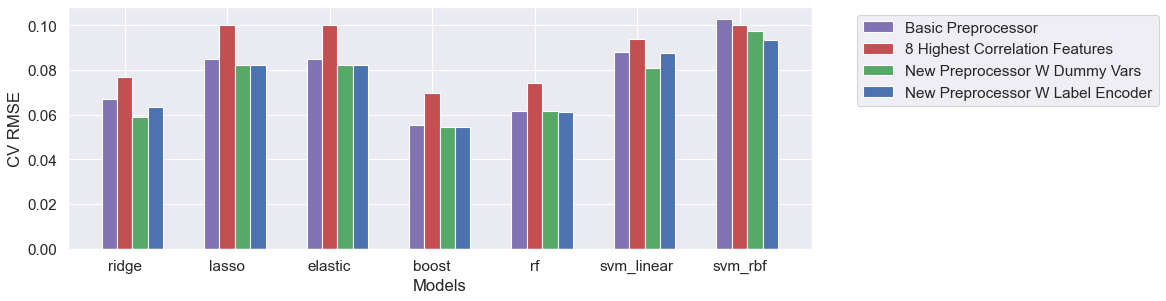

In [ ]:
names = [m[0] for m in models]
barWidth = 0.15

br1 = np.arange(len(names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.figure(figsize=(12,4), dpi=80)

plt.bar(br1, [RMSE_map[f'HP_basic_{name}'][0] for name in names], color='m', width=barWidth, label='Basic Preprocessor')
plt.bar(br2, [RMSE_map[f'{name}'][0] for name in names], color='r', width=barWidth, label='8 Highest Correlation Features')
plt.bar(br3, [RMSE_map[f'HP_{name}'][0] for name in names], color='g', width=barWidth, label='New Preprocessor W Dummy Vars')
plt.bar(br4, [RMSE_map[f'HP_Encoder_{name}'][0] for name in names], color='b', width=barWidth, label='New Preprocessor W Label Encoder')

plt.xlabel('Models')
plt.ylabel('CV RMSE')
plt.xticks([x + barWidth for x in range(len(names))], names)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

This graph above compares the preprocessing method in section 6 with our new preprocessing method. The purple bar is the barebones preprocessor specified in section 3, which merely merely encodes all categorical variables. The red bar is the strategy from section 6 which uses the 8 highest correlated features. The green and red bars use our new preprocessing method. While the green bar's method uses dummy variables to convert categorical variables we felt could not be mapped to numerical values, the blue bar's method merely uses a label encoder. The dummy variable strategy prevents the model from assuming relationships between encodings. For example, if we used the following label encoding for Neighborhood:


```
CollgCr = 1; Veenker = 2; Crawfor = 3; NoRidge = 4;
```

the model might assume that CollegeCr is more similar to Veenker than NoRidge since their values are close together. The solution is to use dummy variables. This creates a new column for each category, assigning a 1 or a 0 if that sample is from said category. The downside of using dummy variables is that the number of features grow significantly. Our dummy variable strategy created a training set with 255 features while our label encoding strategy only has 90.

As we can see, using either feature engineering strategy improves our performance on all models seen above. For most models, the dummy variable preprocessing strategy performs best, with the exception of svm_rbf (and rf, though the difference in rf performance is minimal). This tells us that, given the provided parameters for our model, most of our models were able to find useful patterns in the large number of features. SVM RBF seems to perform better with a smaller number of features, which we can test with slight modifications to our preprocessor. First, we check if dropping the columns used for feature engineering affects performance.


In [ ]:
hp = HousePreprocessor(drop=False, verbose=False)
x_all_drop = pd.concat([x_train, x_test]).reset_index(drop=True)
x_all_drop = hp.process(x_all_drop)

hp_no_drop_x_train = x_all_drop.iloc[:x_train.shape[0], :]
hp_no_drop_x_test = x_all_drop.iloc[x_train.shape[0]:, :]

for name, model in models:
  rmse = cv_rmse(model, hp_no_drop_x_train)

  RMSE_map[f'HP_drop_{name}'] = rmse
  print(f'House Processor W/o Drop {name}: {rmse[0]:.4f} ({rmse[1]:.4f})')

House Processor W/o Drop ridge: 0.0597 (0.0119)
House Processor W/o Drop lasso: 0.0826 (0.0168)
House Processor W/o Drop elastic: 0.0826 (0.0169)
House Processor W/o Drop boost: 0.0540 (0.0069)
House Processor W/o Drop rf: 0.0620 (0.0074)
House Processor W/o Drop svm_linear: 0.0828 (0.0074)
House Processor W/o Drop svm_rbf: 0.1026 (0.0074)


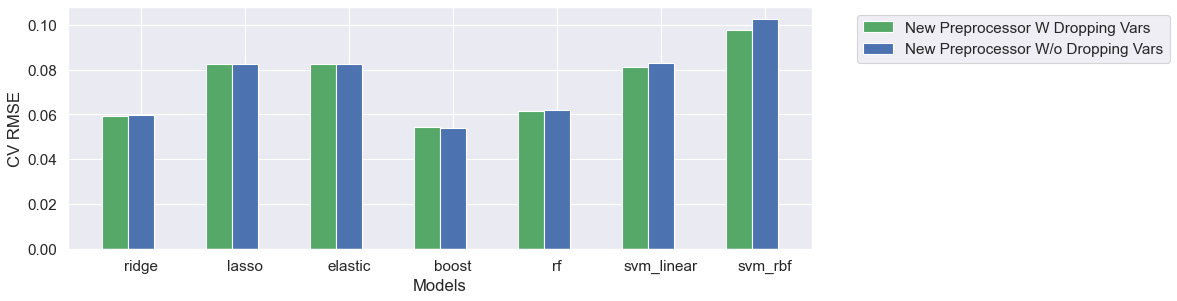

In [ ]:
names = [m[0] for m in models]
barWidth = 0.25

br1 = np.arange(len(names))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(12,4), dpi=80)

plt.bar(br1, [RMSE_map[f'HP_{name}'][0] for name in names], color='g', width=barWidth, label='New Preprocessor W Dropping Vars')
plt.bar(br2, [RMSE_map[f'HP_drop_{name}'][0] for name in names], color='b', width=barWidth, label='New Preprocessor W/o Dropping Vars')

plt.xlabel('Models')
plt.ylabel('CV RMSE')
plt.xticks([x + barWidth for x in range(len(names))], names)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Not dropping the redundant columns reduces performance for most models, though the performance drop is mostly minimal with the exception of svm_rbf. Interestingly, we see a slight increase in performance to the boost model, though the increase is so small we consider it negligible. Since our models seem to function well despite useless features, we see if including both dummy variables and label encoded versions of categorical variables affects performance. 

In [ ]:
hp = HousePreprocessor(drop=True, verbose=False)
x_all_drop = pd.concat([x_train, x_test]).reset_index(drop=True)
x_all_drop = hp.process(x_all_drop)

hp_enc_and_dum_x_train = x_all_drop.iloc[:x_train.shape[0], :]
hp_enc_and_dum_x_test = x_all_drop.iloc[x_train.shape[0]:, :]

for name, model in models:
  rmse = cv_rmse(model, hp_enc_and_dum_x_train)

  RMSE_map[f'HP_enc_and_dum_{name}'] = rmse
  print(f'House Processor W/o Drop {name}: {rmse[0]:.4f} ({rmse[1]:.4f})')

House Processor W/o Drop ridge: 0.0591 (0.0109)
House Processor W/o Drop lasso: 0.0823 (0.0164)
House Processor W/o Drop elastic: 0.0823 (0.0164)
House Processor W/o Drop boost: 0.0543 (0.0072)
House Processor W/o Drop rf: 0.0615 (0.0068)
House Processor W/o Drop svm_linear: 0.0810 (0.0064)
House Processor W/o Drop svm_rbf: 0.0974 (0.0056)


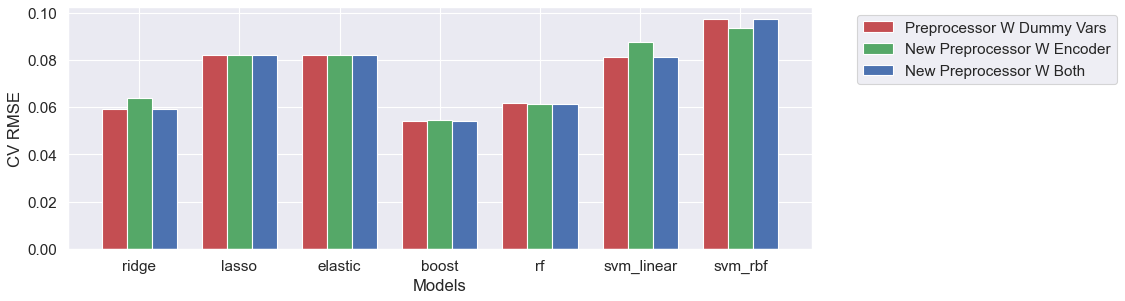

In [ ]:
names = [m[0] for m in models]
barWidth = 0.25

br1 = np.arange(len(names))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.figure(figsize=(12,4), dpi=80)

plt.bar(br1, [RMSE_map[f'HP_{name}'][0] for name in names], color='r', width=barWidth, label='Preprocessor W Dummy Vars')
plt.bar(br2, [RMSE_map[f'HP_Encoder_{name}'][0] for name in names], color='g', width=barWidth, label='New Preprocessor W Encoder')
plt.bar(br3, [RMSE_map[f'HP_enc_and_dum_{name}'][0] for name in names], color='b', width=barWidth, label='New Preprocessor W Both')


plt.xlabel('Models')
plt.ylabel('CV RMSE')
plt.xticks([x + barWidth for x in range(len(names))], names)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

While we see no improvement, other than a negligibly small improvement to our boost model, the strategy of using both dummy variables and label encodings works as well as the best of the two strategies on their own, with the exception of SVM RBF. Based on our first test, this further shows that SVM RBF performs best with fewer features.

## Feature Selection

We further experimented with feature selection to see if they would provide solutions to our models. Since we hypothesized above that SVM RBF performs better with less features, we will only show results of SVM RBF's performance with our selected features.

## Boruta

In [ ]:
import numpy as np
np.random.seed(12)

# Heavy Influence for Boruta Implementation from https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

### initialize hits counter
hits = np.zeros((len(hp_x_train.columns)))

### repeat 20 times
trials = 20
for iter_ in list(range(trials)):
    X_shadow = hp_x_train.apply(np.random.permutation)
    X_shadow.columns = ['shadow_' + feat for feat in hp_x_train.columns] ### make X_boruta by appending X_shadow to X
    X_boruta = pd.concat([hp_x_train, X_shadow], axis = 1)

    forest = RandomForestRegressor(random_state = 12)
    forest.fit(X_boruta, y_train)
    
    feat_imp_X = forest.feature_importances_[:len(hp_x_train.columns)]
    feat_imp_shadow = forest.feature_importances_[len(hp_x_train.columns):]

    ### compute hits
    hits += feat_imp_X > feat_imp_shadow.max()

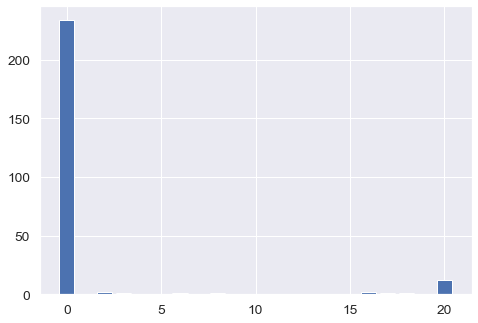

Number of features with more >= 0 hits: 255
Number of features with more >= 1 hits: 21
Number of features with more >= 5 hits: 18
Number of features with more >= 10 hits: 16
Number of features with more >= 15 hits: 16
Number of features with more >= 20 hits: 12

21 best features are ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenQual', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'YearBuiltSum', 'Total_Indoor_SF']


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
nums = list(range(0,trials+1))
vals = [list(hits).count(num) for num in nums]
ax.bar(nums, vals)
plt.show()
for i in ([0,1] + [v for v in range(5,trials+1, 5)]):
    print(f"Number of features with more >= {i} hits:", len([hit for hit in hits if hit >= i]))

print(f"\n{len([hit for hit in hits if hit >= 1])} best features are {[hp_x_train.columns[index] for index, hit in enumerate(hits) if hit >= 1]}")

In [ ]:
model = svm_rbf
svm_hit_rmses = []
for i in ([0,1] + [v for v in range(5,trials+1, 5)]):
  rmse = cv_rmse(model, hp_x_train[[hp_x_train.columns[index] for index, hit in enumerate(hits) if hit >= i]])

  RMSE_map[f'svm_rbf_>=_{i}_hits'] = rmse
  print(f'SVM RBF {i} hits: {rmse[0]:.4f} ({rmse[1]:.4f})')

  svm_hit_rmses.append(rmse[0])

SVM RBF 0 hits: 0.0974 (0.0056)
SVM RBF 1 hits: 0.0914 (0.0046)
SVM RBF 5 hits: 0.0895 (0.0036)
SVM RBF 10 hits: 0.0882 (0.0047)
SVM RBF 15 hits: 0.0882 (0.0047)
SVM RBF 20 hits: 0.0877 (0.0038)


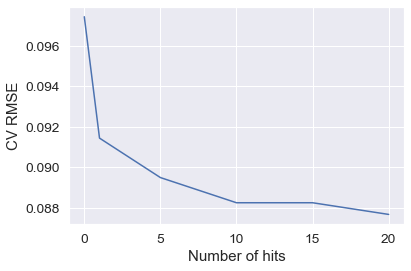

In [ ]:
barWidth = 0.5

plt.plot(([0,1] + [v for v in range(5,trials+1, 5)]), svm_hit_rmses)


plt.xlabel('Number of hits')
plt.ylabel('CV RMSE')
plt.show()

As predicted, reducing the number of unhelpful features improved the performance of SVM RBF. In this case, our strategy for selecting features. This feature selection is handled through the boruta method. Boruta works by concatenating randomized columns of each variable to our training dataframe and using a random forest to filter out any training variables that perform worse than the best randomized column. We give a variable a "hit" in each iteration of the Boruta method where said variable is not filtered out. While it is impressive that only 12 features can achieve such an accuracy, the final accuracy is still worse than all other models tested.

## K-Best Feature Selection
This section uses the sklearn feature selection class to attempt to improve SVM RBF's performance

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_selection import SelectKBest
 

max_feats = hp_x_train.shape[1]
num_feats = [max_feats] + list(range(max_feats - (max_feats % 20),0, -20))

svm_k_best_rmses = []
for i in num_feats:
  x_new = SelectKBest(k=i).fit_transform(hp_x_train, y_train)
  rmse = cv_rmse(model, x_new)

  RMSE_map[f'svm_rbf_{i}_best'] = rmse
  print(f'SVM RBF {i} best: {rmse[0]:.4f} ({rmse[1]:.4f})')

  svm_k_best_rmses.append(rmse[0])

SVM RBF 255 best: 0.0974 (0.0056)
SVM RBF 240 best: 0.0974 (0.0056)
SVM RBF 220 best: 0.0974 (0.0060)
SVM RBF 200 best: 0.0993 (0.0043)
SVM RBF 180 best: 0.1025 (0.0038)
SVM RBF 160 best: 0.1022 (0.0039)
SVM RBF 140 best: 0.1027 (0.0035)
SVM RBF 120 best: 0.1015 (0.0045)
SVM RBF 100 best: 0.1037 (0.0058)
SVM RBF 80 best: 0.1034 (0.0047)
SVM RBF 60 best: 0.1001 (0.0048)
SVM RBF 40 best: 0.0997 (0.0042)
SVM RBF 20 best: 0.0942 (0.0037)


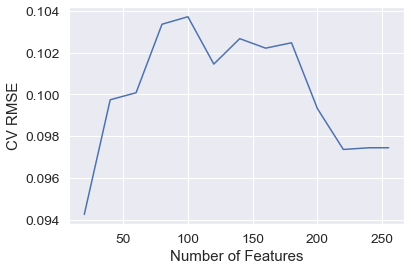

In [ ]:
barWidth = 0.5

plt.plot(num_feats, svm_k_best_rmses)


plt.xlabel('Number of Features')
plt.ylabel('CV RMSE')
plt.show()

While the model performs best at only 20 features, the model performs worse with the feature selection at 20-220 features than it does at 255. In this experiment, Sklearn's SelectKBest algorithm does perform well on our data as it makes our SVM RBF model perform worse with many of its selections.

# Conclusion and Main Takeaways

### Different Models Need Different Things

Through our testing and research on many different types of models, it was interesting to observe the differences between the different types of models. Some feature engineering strategies worked great for some models while reducing performance for others. Overtime, we learned the weaknesses and strengths of each model. Through parameter tuning and changes to our preprocessing, we could experiment on one model and later observe how the changes might affect the overall stack model or how the preprocessing would affect other individual models.

As we observe from the graph below, while some feature engineering steps proved to be helpful across the board, different models benefited from different strategies. Some perform better with dummy variables while others prefered an encoding strategy. SVM RBF seemed to work best with feature selection. Every model seems to have its own complexities and designing the preprocessor to easily change its functionality through keyword arguments allows us to iterate quickly as we test different strategies.

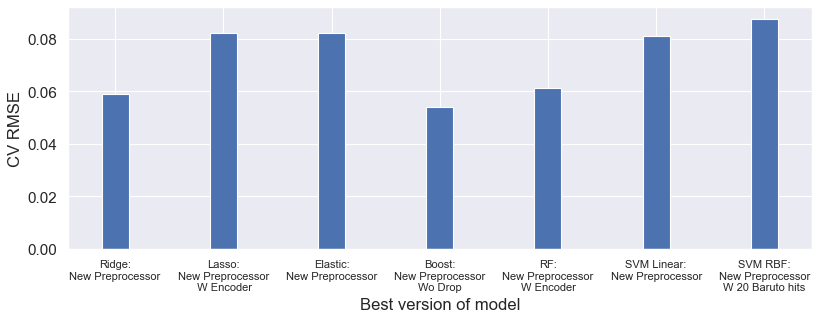

In [ ]:
names = [m[0] for m in models]

best = [min([(k,v) for k,v in RMSE_map.items() if name in k], key=lambda x: x[1][0]) for name in names]

barWidth = 0.25

plt.figure(figsize=(12,4), dpi=80)

br1 = np.arange(len(best))
plt.rcParams['xtick.labelsize'] = 10

best_names = ["Ridge:\nNew Preprocessor", "Lasso:\nNew Preprocessor\n W Encoder", "Elastic:\nNew Preprocessor", "Boost:\nNew Preprocessor\nWo Drop", "RF:\nNew Preprocessor\nW Encoder", "SVM Linear:\nNew Preprocessor", "SVM RBF:\nNew Preprocessor\nW 20 Baruto hits"]
plt.bar(best_names, [b[1][0] for b in best], width=barWidth)

plt.xlabel('Best version of model')
plt.ylabel('CV RMSE')
# plt.xticks([x + barWidth for x in range(len(names))], names)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Neural Networks are not Always the Best Solution
When researching machine learning, it is common to hear about neural network-based strategies for solving machine learning problems. As a result, our team spent a lot of time, especially in our initial experiments, trying to tune a neural networks solution to achieve results. It was only when we opted to explore other machine learning models that we found significant improvements in our score. While neural networks might be optimal in other tasks, there are many strategies for tackling machine learning problems that might have equal or even better results. By having an open mind and a willingness to experiment, we can achieve great results.

### There is no Magic Model, Machine Learning is an iterative process
While experimenting for this project, we often found ourselves often hoping to ourselves that this change will be the magic step that will drastically improve our models performance, whether that change be using a new model, different feature engineering techniques, or some parameter tuning. We found that while our changes would affect the model's performance, the performance difference would be small. We learned overtime that machine learning projects are not about getting lucky and finding that perfect model for your dataset. Instead, it is an iterative process, slowly making changes and experimenting to find better results over time. Through an amalgamation of changes such as improving your feature engineering, trying different models, tuning parameters, we will eventually see the results we are looking for. This is a valuable lesson that we are excited to use as we work on more complex machine learning tasks.

# References

https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

https://www.youtube.com/watch?v=iYie42M1ZyU&t=2168s

Géron A. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media, Incorporated; 2019.


# End of Notebook